## Some data exploration

In [1]:
# import statements 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model  import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict
import datetime as dt

quick look at the Sambanis dataset

In [4]:
# 88 variables specified in Sambanis 2006, found in R code
cols_sambanis = ["warstds", "ager", "agexp", "anoc", "army85", "autch98", "auto4",
        "autonomy", "avgnabo", "centpol3", "cowcode", "coldwar", "decade1", "decade2",
        "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel",
        "durable", "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590",
        "expgdp", "exrec", "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2",
        "geo34", "geo57", "geo69", "geo8", "illiteracy", "incumb", "infant",
        "inst", "inst3", "life", "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper",
        "mirps0", "mirps1", "mirps2", "mirps3", "nat_war", "ncontig",
        "nmgdp", "nmdp4_alt", "numlang", "nwstate", "oil", "p4mchg",
        "parcomp", "parreg", "part", "partfree", "plural", "plurrel",
        "pol4", "pol4m", "pol4sq", "polch98", "polcomp", "popdense",
        "presi", "pri", "proxregc", "ptime", "reg", "regd4_alt", "relfrac", "seceduc",
        "second", "semipol3", "sip2", "sxpnew", "sxpsq", "tnatwar", "trade",
        "warhist", "xconst", "year"]

sambanis = pd.read_csv("SambnisImp.csv", usecols=cols_sambanis)
print(f'Sambanis dataset has {sambanis.shape[0]} rows with {sambanis.shape[1]} features.')
#civil_war contains only the observations with a civil war
civil_war = sambanis[sambanis["warstds"]==1]
print(f'There are {civil_war.shape[0]} civil war in the dataset.')
nb_country_cw = len(civil_war['cowcode'].value_counts())
print(f'There are {nb_country_cw} different country which had a CW (some countries had multiple CW)')
print(f'The data ranges from 1945 to 2000. The first CW dates form {min(civil_war.year)} and the last {max(civil_war.year)}')

Sambanis dataset has 7140 rows with 93 features.
There are 116 civil war in the dataset.
There are 72 different country which had a CW (some countries had multiple CW)
The data ranges from 1945 to 2000. The first CW dates form 1946 and the last 1999


In [19]:
var2label_s = dict({
    "sxpsq":"Primary Commodity Exports (Squared)",
    "sxpnew":"Primary Commodity Exports",
    "agexp":"Agricultural Raw Materials Exports",
    "illiteracy":"Illiteracy Rate",
    "manuexp":"Manufactures Exports",
    "milper":"Military Power",
    "fuelexp":"Fuel and Oil Exports",
    "gdpgrowth":"GDP Growth",
    "lpopns": "Population (logged)",
    "trade":"Trade as Percent of GDP",
    "expgdp":"Goods & Services Exports",
    "nmgdp":"Neighbors' average GDP per capita)",
    "popdense":"Population Density",
    "ln_gdpen":"GDP per Capita (logged)",
    "ptime":"ptime = ???",
    "avgnabo":"Average SUP score of neighbors",
    "pri":"Primary Education",
    "ager":"Goverment age",
    "infant":"Infant mortality",
    "durable":"Year since last regime transition",
    "life":"Life Expectancy",
    "seceduc":"Secondary Education",
    "dlang":"Linguistic Hetrogeneity",
    "partfree":"Anocracy",
    "part":"ln(Share of population voting x opposition's share \
of votes cast)",
    "p4mchg":"Annual change in modified polity, Polity IV",
    "demch98":"Democracy annual change; Polity 98",
    "dem":"Democracy",
    "incumb":"Consolidation of incumbent advantages (Przeworksi \
et al., 2000)",
    "army85":"Military Power",
    "major":"Majoritatian system",
    "semipol3": "Semi-federal state, Polity III",
    "oil":"Oil Exports per GDP",
    "lmtnest":"Rough Terrain",
    "autonomy":"Country has de facto autonomous regions",
    "sip2":"Continuous measure of democracy",
    "ehet":"Ethnic Heterogeneity",
    "ef":"Ethnic Fractionalization",
    "regd4_alt":"Median Regional Polity Score",
    "pol4sq":"Polity Index squarred",
    "presi":"Presidential system",
    "proxregc":"Regime Transition Score",
    "inst3":"Political Instability",
    "xconst":"Executive constraints - operational independence of CE",  
})

quick look at trade_reg.csv. created from Trade-Register-1950-2000.txt

In [5]:
trade = pd.read_csv("trade_reg.csv",sep='\t')

In [96]:
print(f'The data ranges from {min(trade.year_order)} to {max(trade.year_order)}.')
#number of transaction
trade.supplier.value_counts()[:15]

The data ranges from 1940-01-01 00:00:00 to 2000-01-01 00:00:00.


United States          6226
Soviet Union           3358
France                 1854
United Kingdom         1689
Germany                 706
Italy                   576
China                   433
Russia                  351
Canada                  326
Netherlands             324
Sweden                  216
Israel                  215
Switzerland             209
Unknown supplier(s)     141
Ukraine                 110
Name: supplier, dtype: int64

In [97]:
#number of transaction
trade.recipient.value_counts()[:15]

Egypt          433
India          427
Turkey         409
Greece         407
Thailand       382
Israel         314
South Korea    313
Spain          299
Argentina      298
Taiwan         297
Pakistan       290
Iran           289
Japan          284
Iraq           284
Indonesia      284
Name: recipient, dtype: int64

Adding the "country" column in sambanis dataset based on the cowcodes

In [10]:
#loading the cowcode dataset
cowcodes = pd.read_csv("COW_country_codes.csv")
cowcodes = cowcodes.rename(columns={'CCode': 'cowcode', 'StateNme':'country'})
#create the dictionaries
dict_cowcode = dict(zip(cowcodes.cowcode,cowcodes.country))
dict_cowcode_abb = dict(zip(cowcodes.cowcode,cowcodes.StateAbb))

sambanis['country'] = sambanis.cowcode.map(dict_cowcode)
sambanis['country_abb'] =sambanis.cowcode.map(dict_cowcode_abb) 
#don't know if it is necessary to add the abbreviation but I figured it could be useful

Counting how many countries who had a civil war were also the recipient of weapons within a time range

In [11]:
trade.year_order = trade.year_order.str.strip('( )') 
#j'ai juste enlevé les parenthèse mais je sais pas si on devrait garder ces lignes ou pas
#trade.recipient = trade.recipient.str.strip(' ')

#transform to datetime
sambanis['year'] = pd.to_datetime(sambanis['year'],format='%Y')
trade['year_order'] = pd.to_datetime(trade['year_order'],format='%Y')

In [12]:
civil_war = sambanis[sambanis["warstds"]==1]
civil_war['import_weapons'] = 0

<ipython-input-12-7ab86b3c87f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  civil_war['import_weapons'] = 0


In [13]:
for id in civil_war.index:
    country = civil_war.country.loc[id]
    date = civil_war.year.loc[id]
    start = date + dt.timedelta(days=-365) # 3 years, to be changed?
    end = date + dt.timedelta(days=365)
    mask = (trade['year_order'] >= start) & (trade['year_order'] <= end)
    trade_tmp = trade.loc[mask]
    if (trade_tmp.recipient.str.contains(country).sum()>0):
        civil_war.loc[id,'import_weapons'] = 1

/home/toinou/Documents/venvs/pyt3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [14]:
#number of civil war "accompagnied" by weaponery transactions
civil_war['import_weapons'].sum() 

82

In [83]:
def plot_feat(df, country, feat, var2label=var2label_s,
              ax=None, title=None):
    tmp=df.loc[df["country"]==country]
    if ax != None:
        ax.scatter(tmp.year, tmp[feat])
        for onset in tmp.loc[tmp["warstds"] == 1]["year"]:
            ax.axvline(x=onset, c='r')
        ax.set_title(title)
    else:
        plt.scatter(tmp.year, tmp[feat])
        for onset in tmp.loc[tmp["warstds"] == 1]["year"]:
            plt.axvline(x=onset, c='r')
        plt.title(var2label[feat])
        plt.show()      

In [84]:
#"high importance features" ~ (cf Random Forest)
feat_subset = [ "sxpnew",
                "illiteracy",
                "milper",
                "gdpgrowth",
                "lpopns",
                "pri",
                "infant",
                "life",
                "seceduc"
              ]

#list of countries affected by at least 1 CW
CW_countries = list(sambanis.loc[sambanis["warstds"]==1]["country"].drop_duplicates())

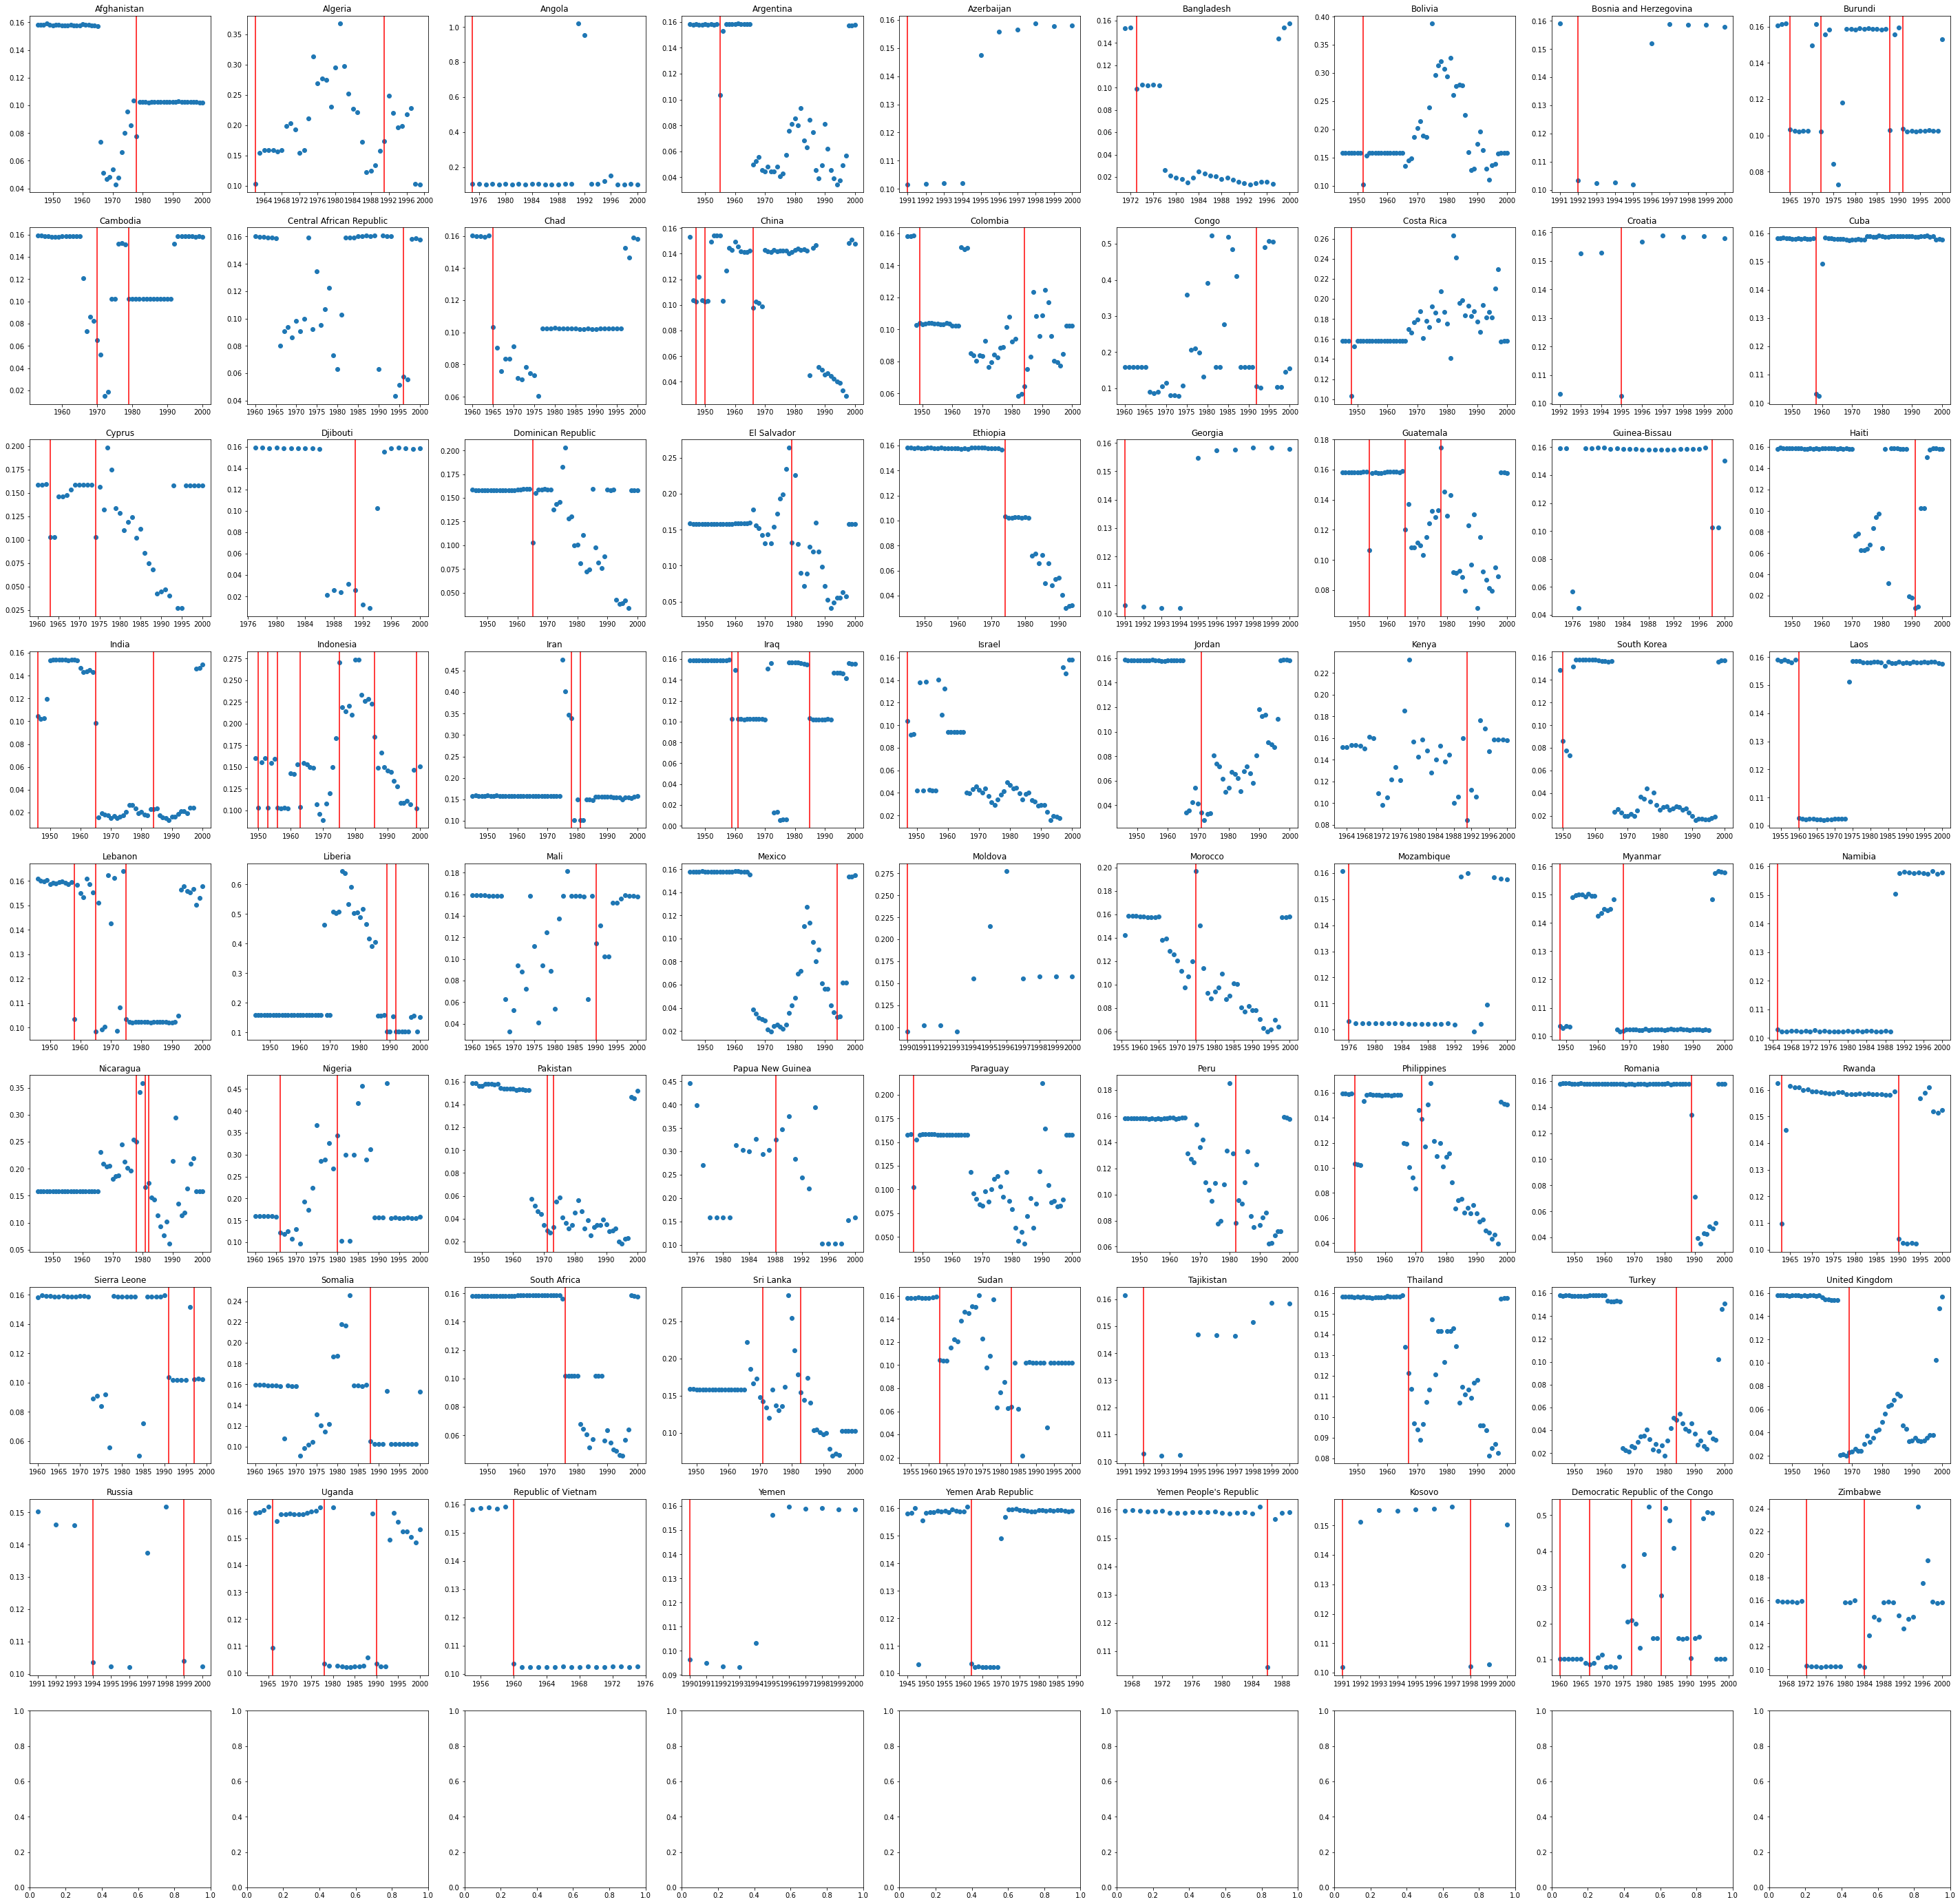

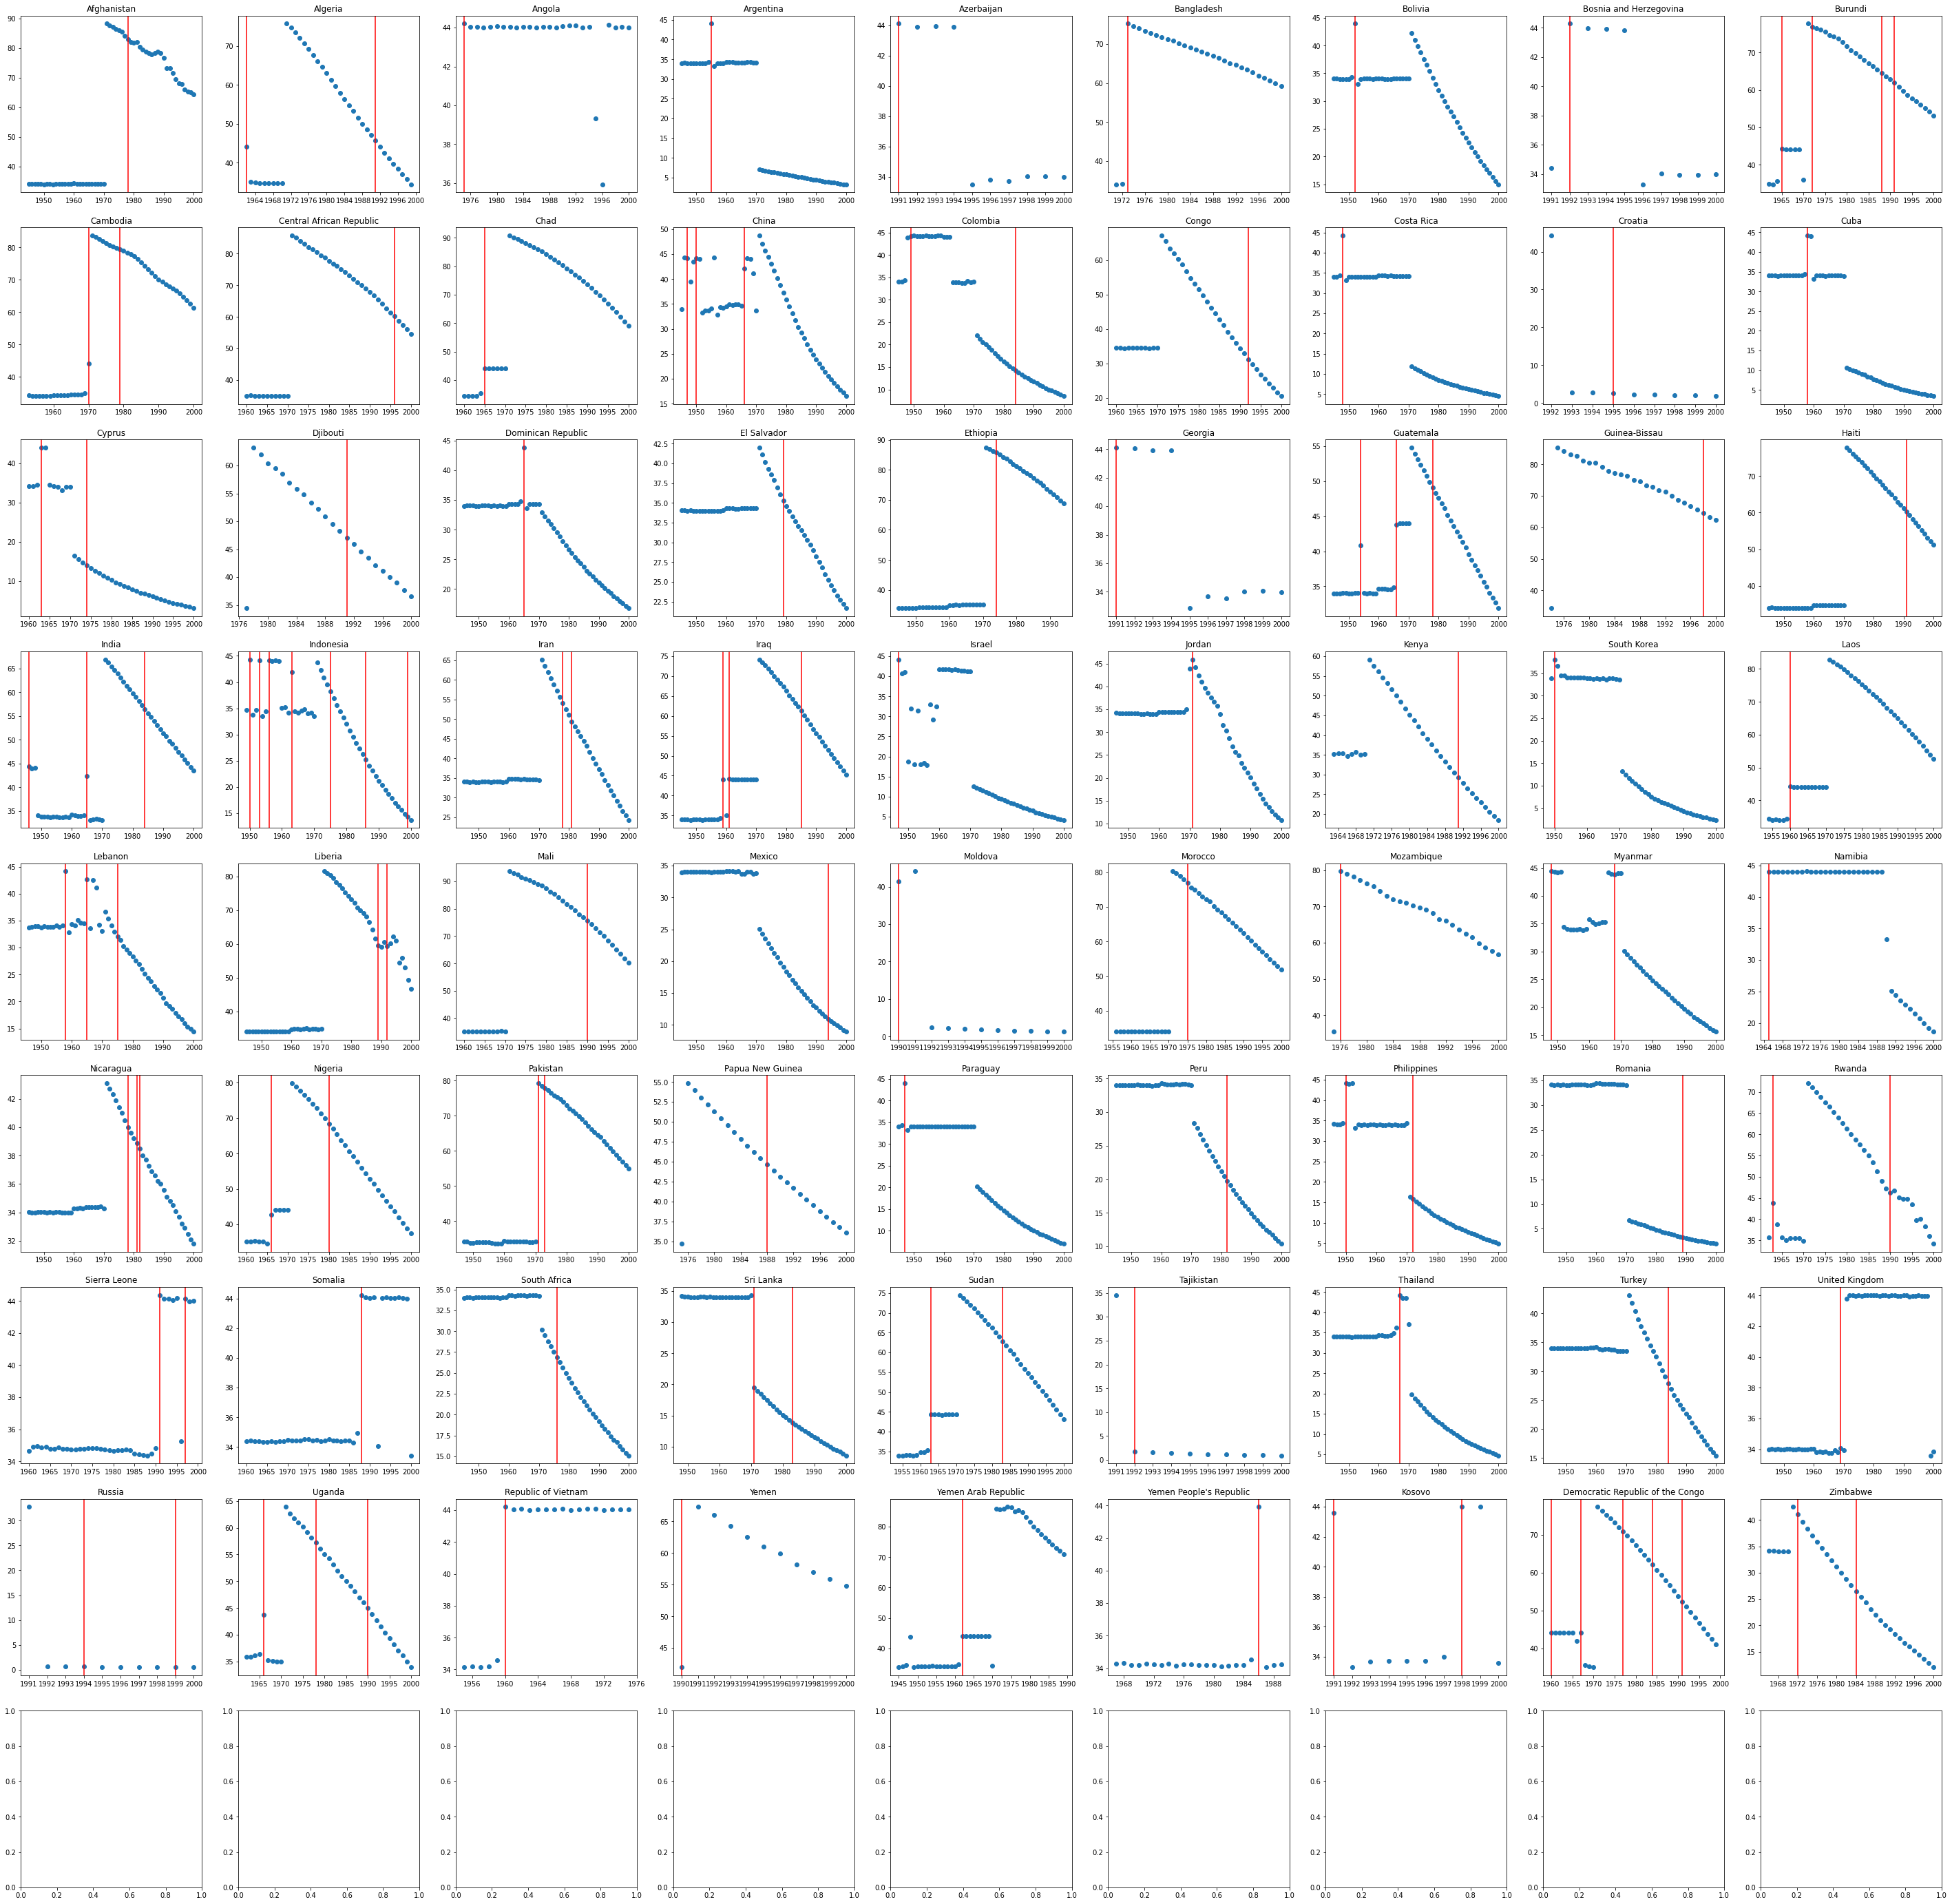

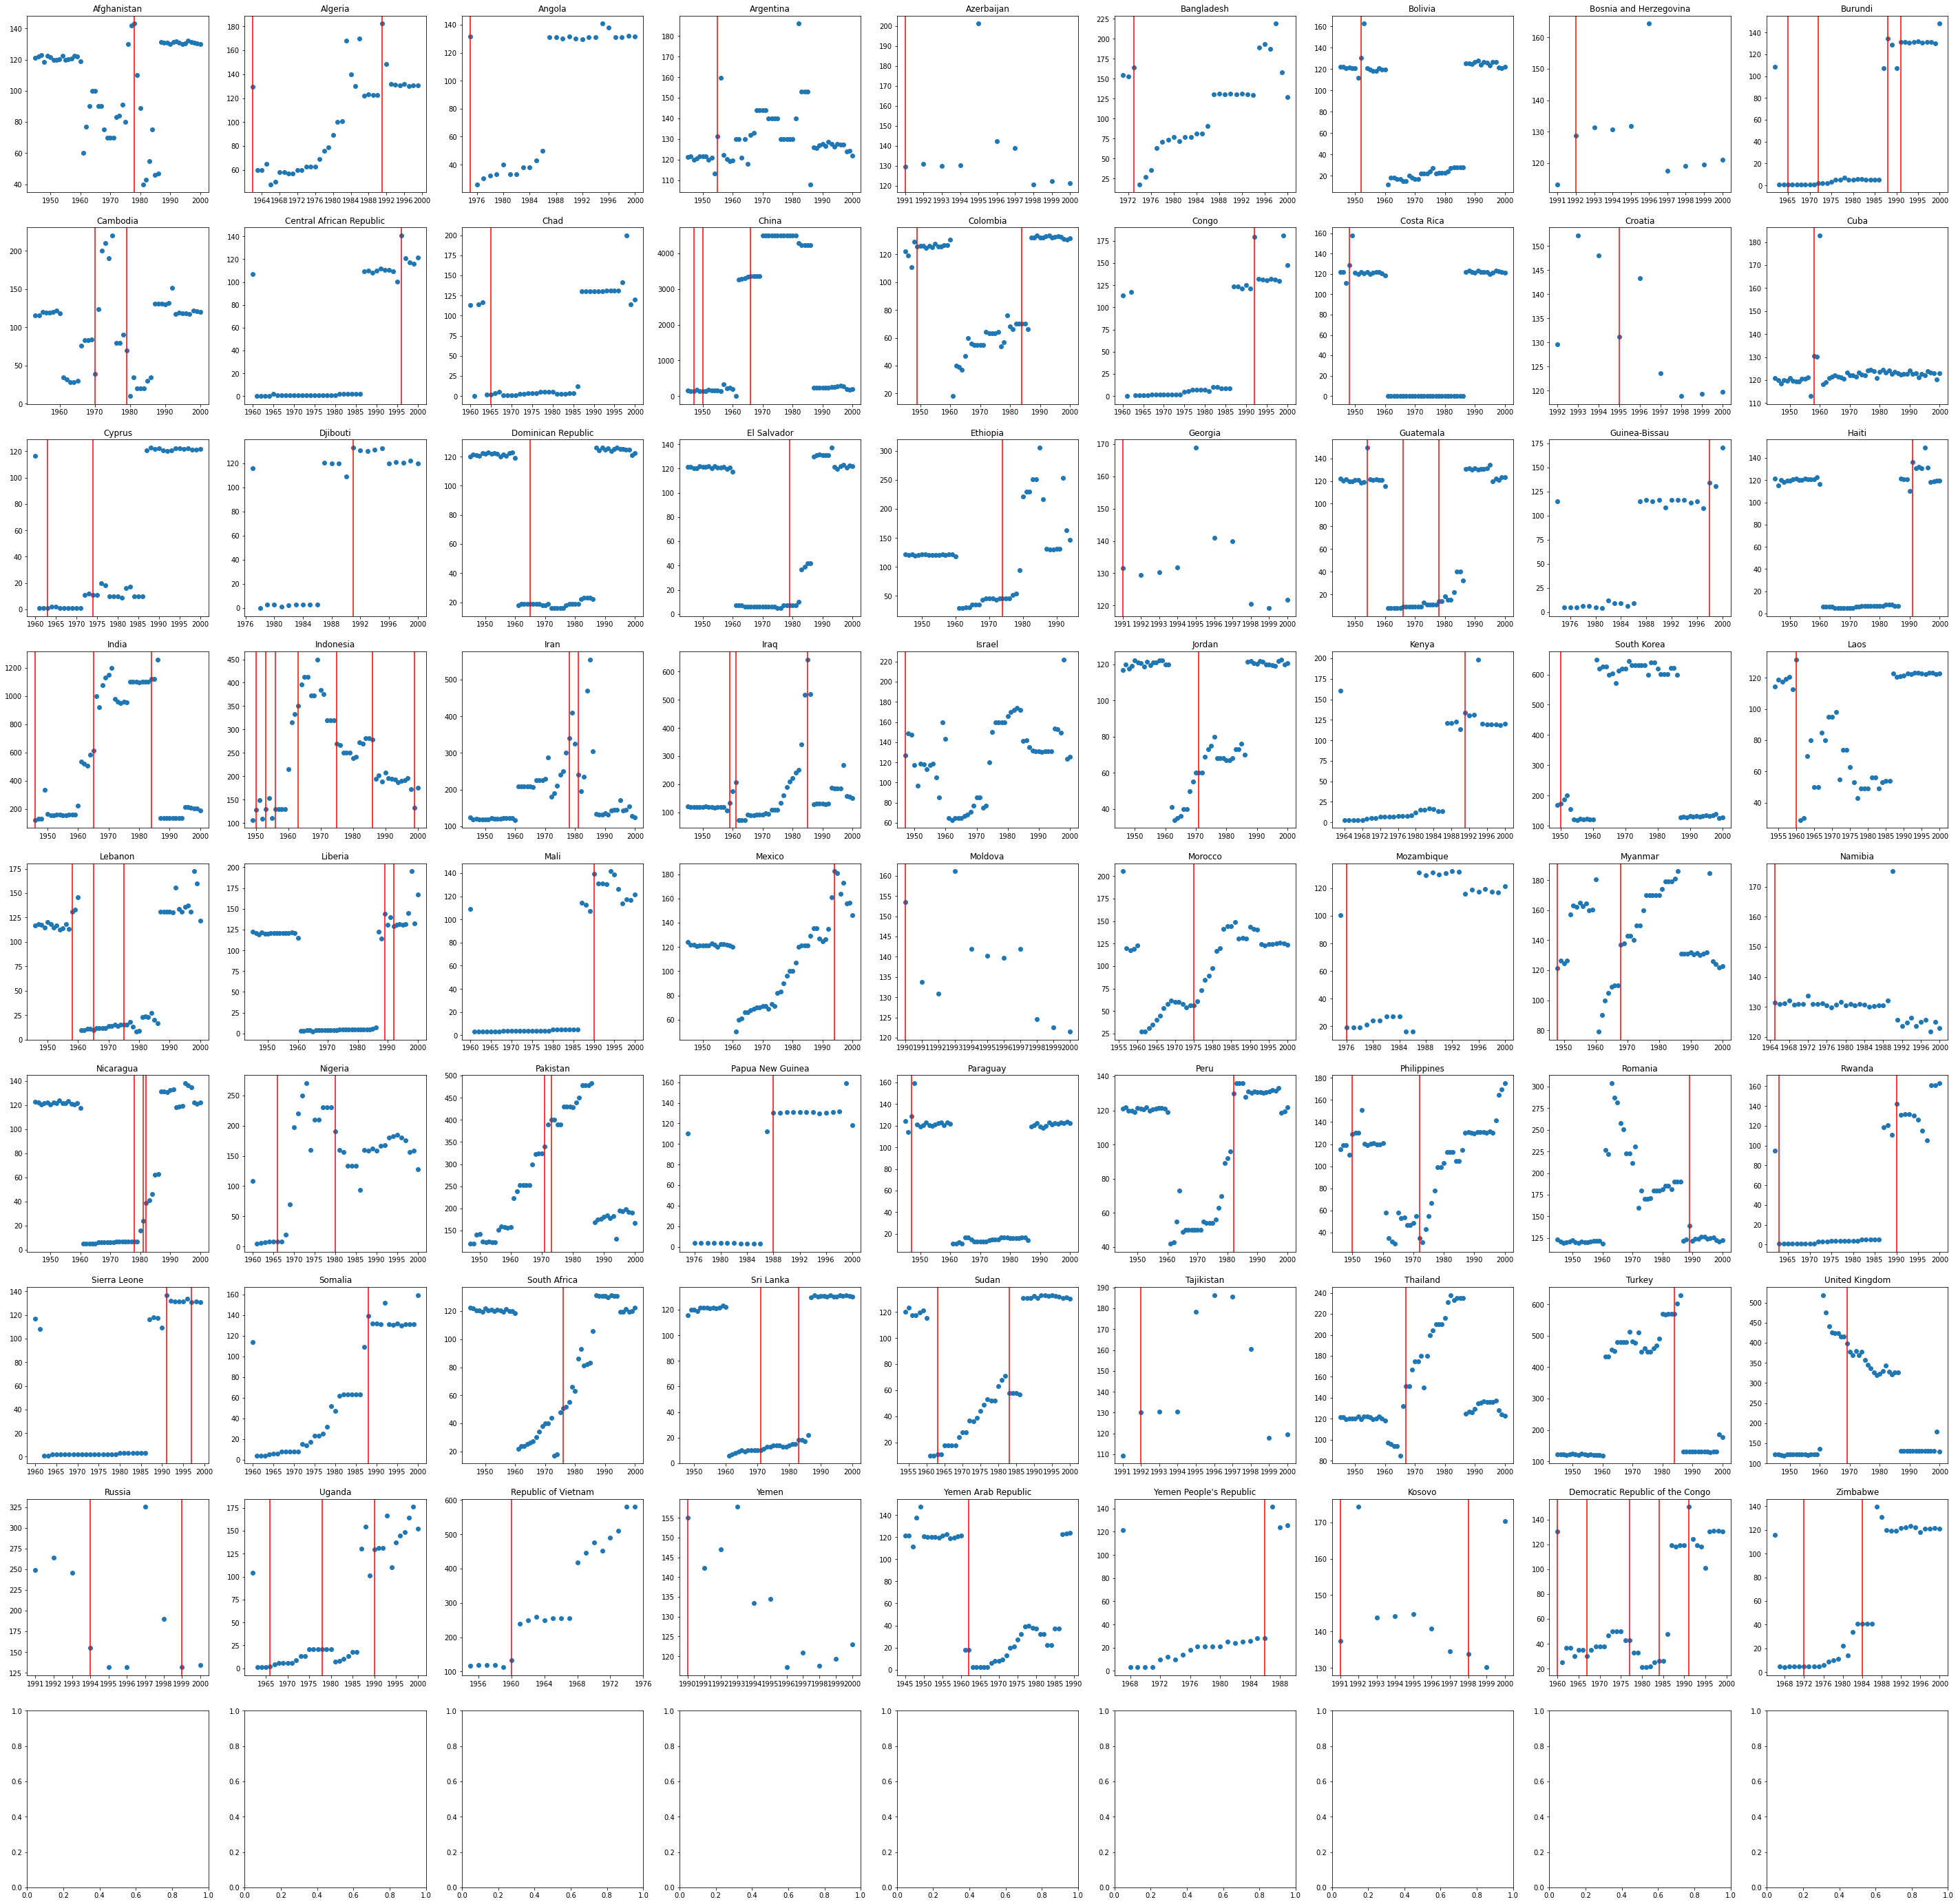

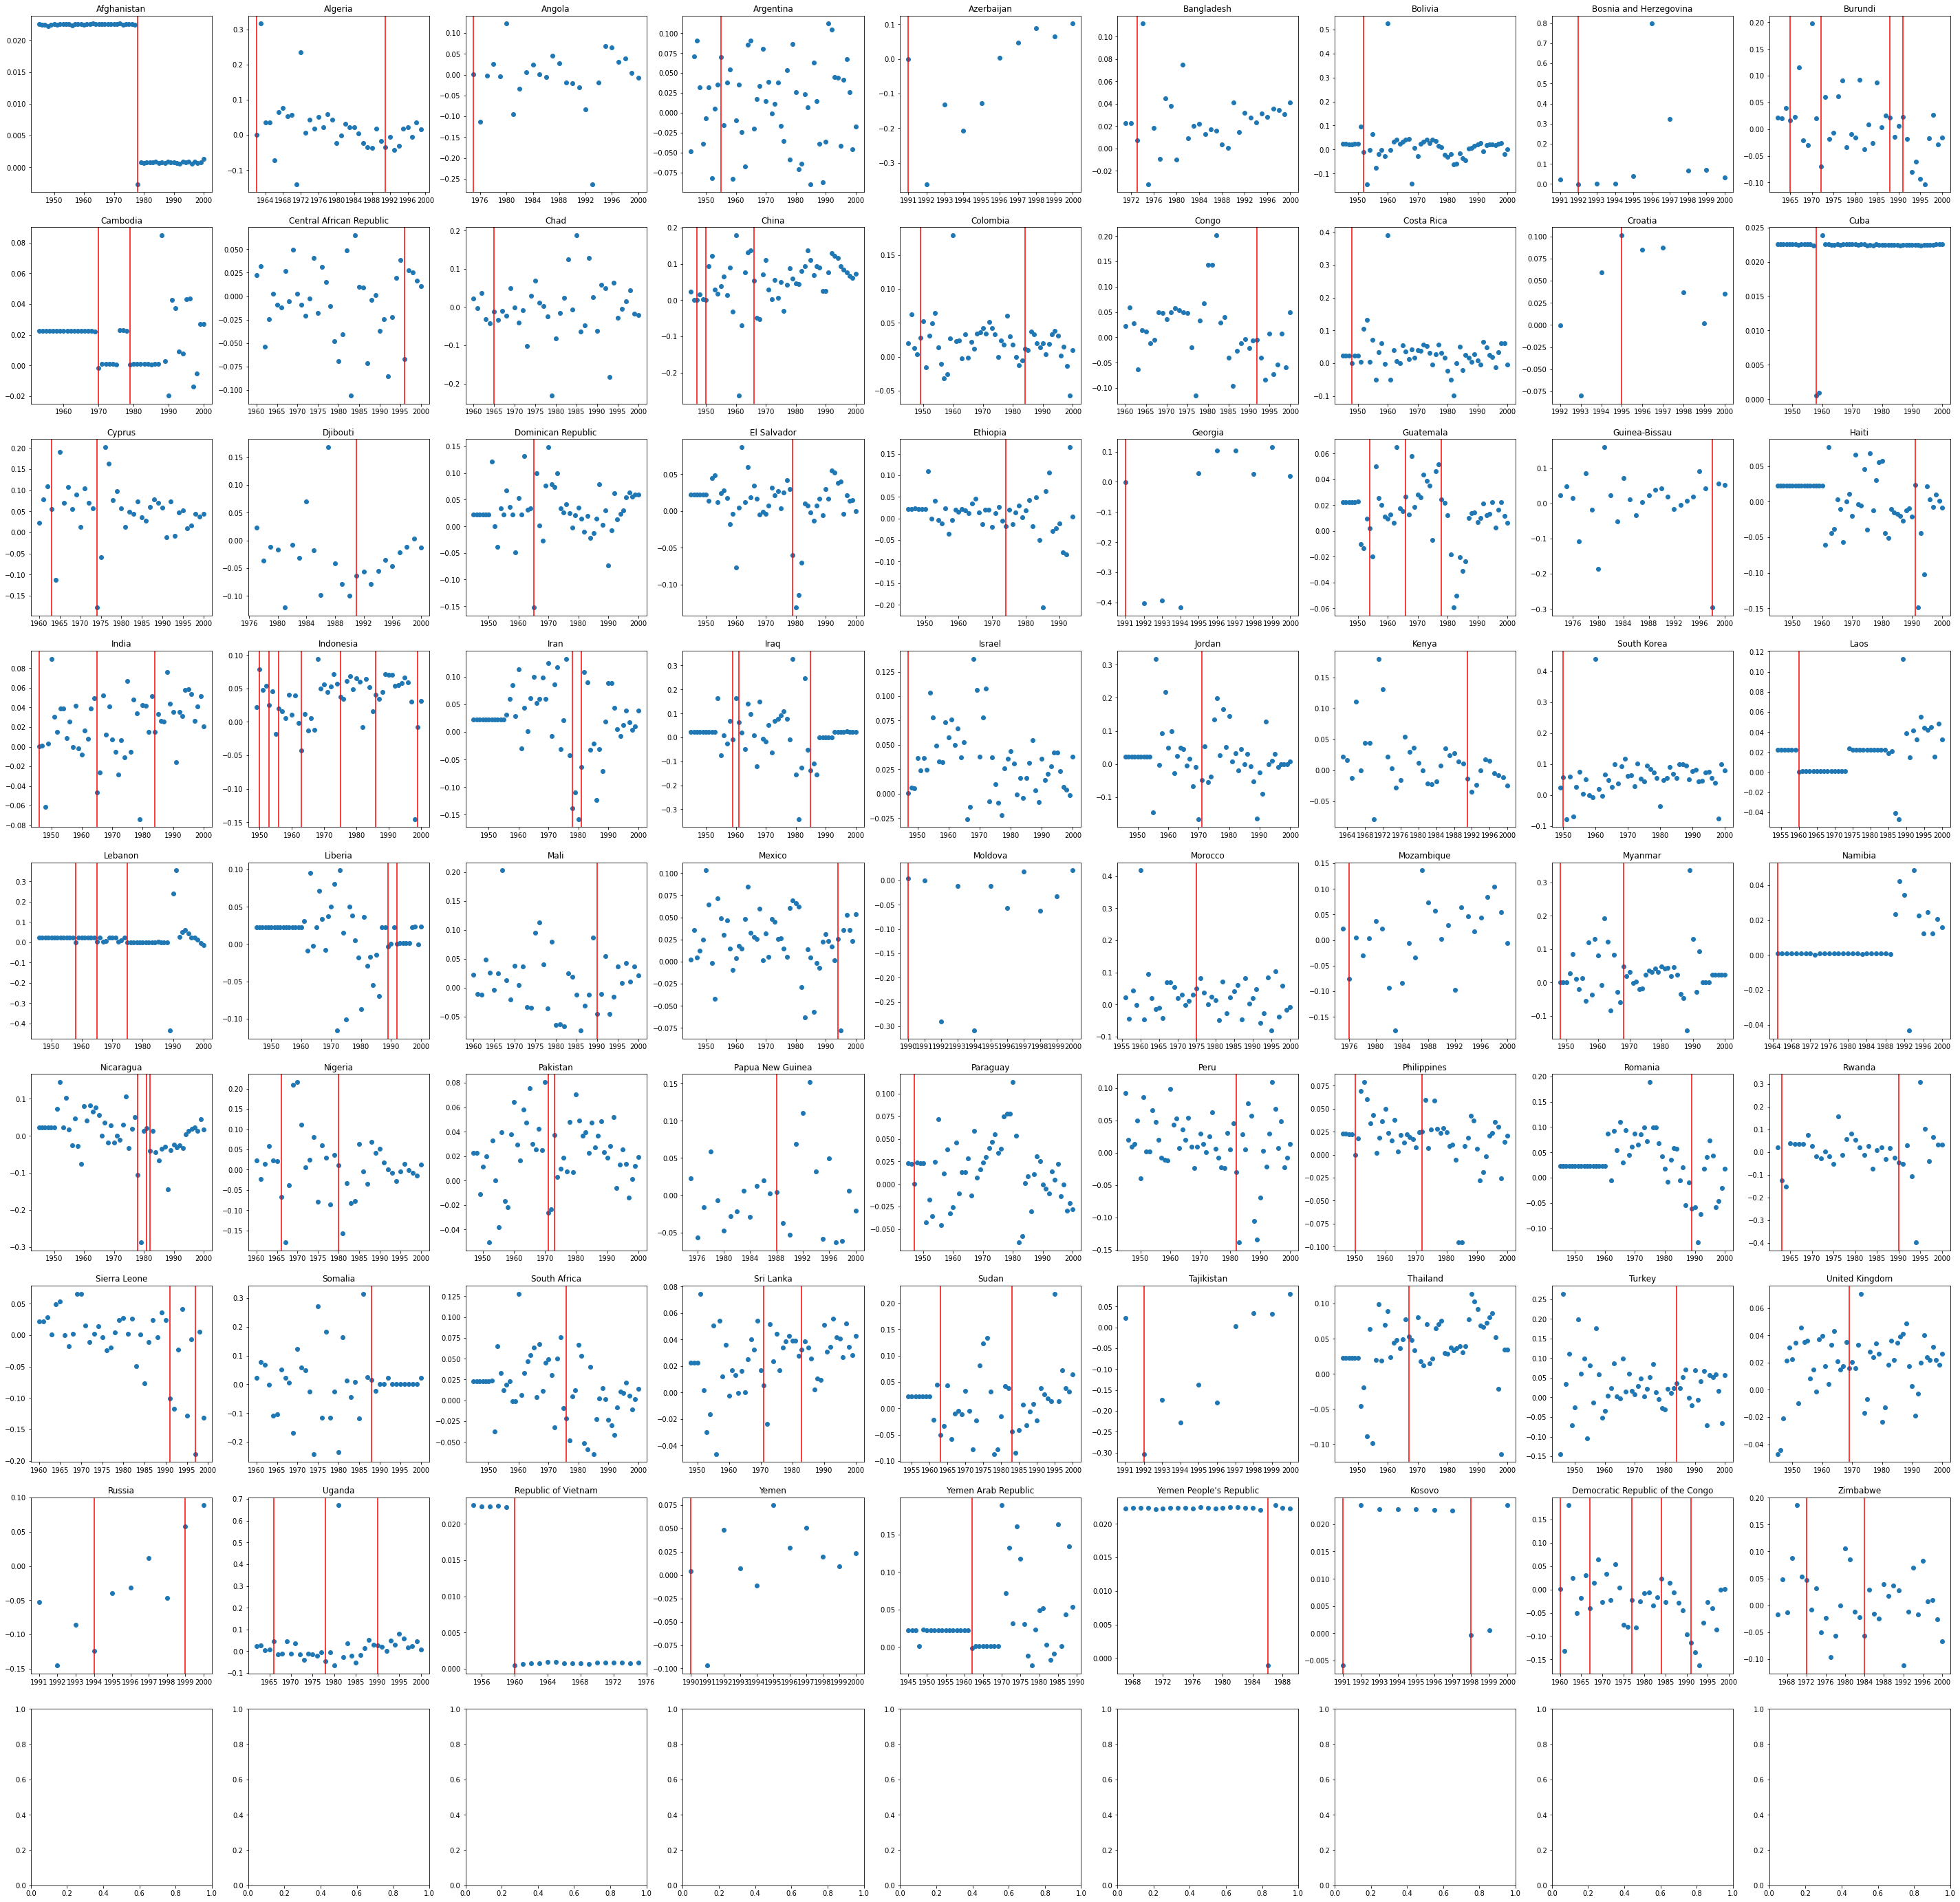

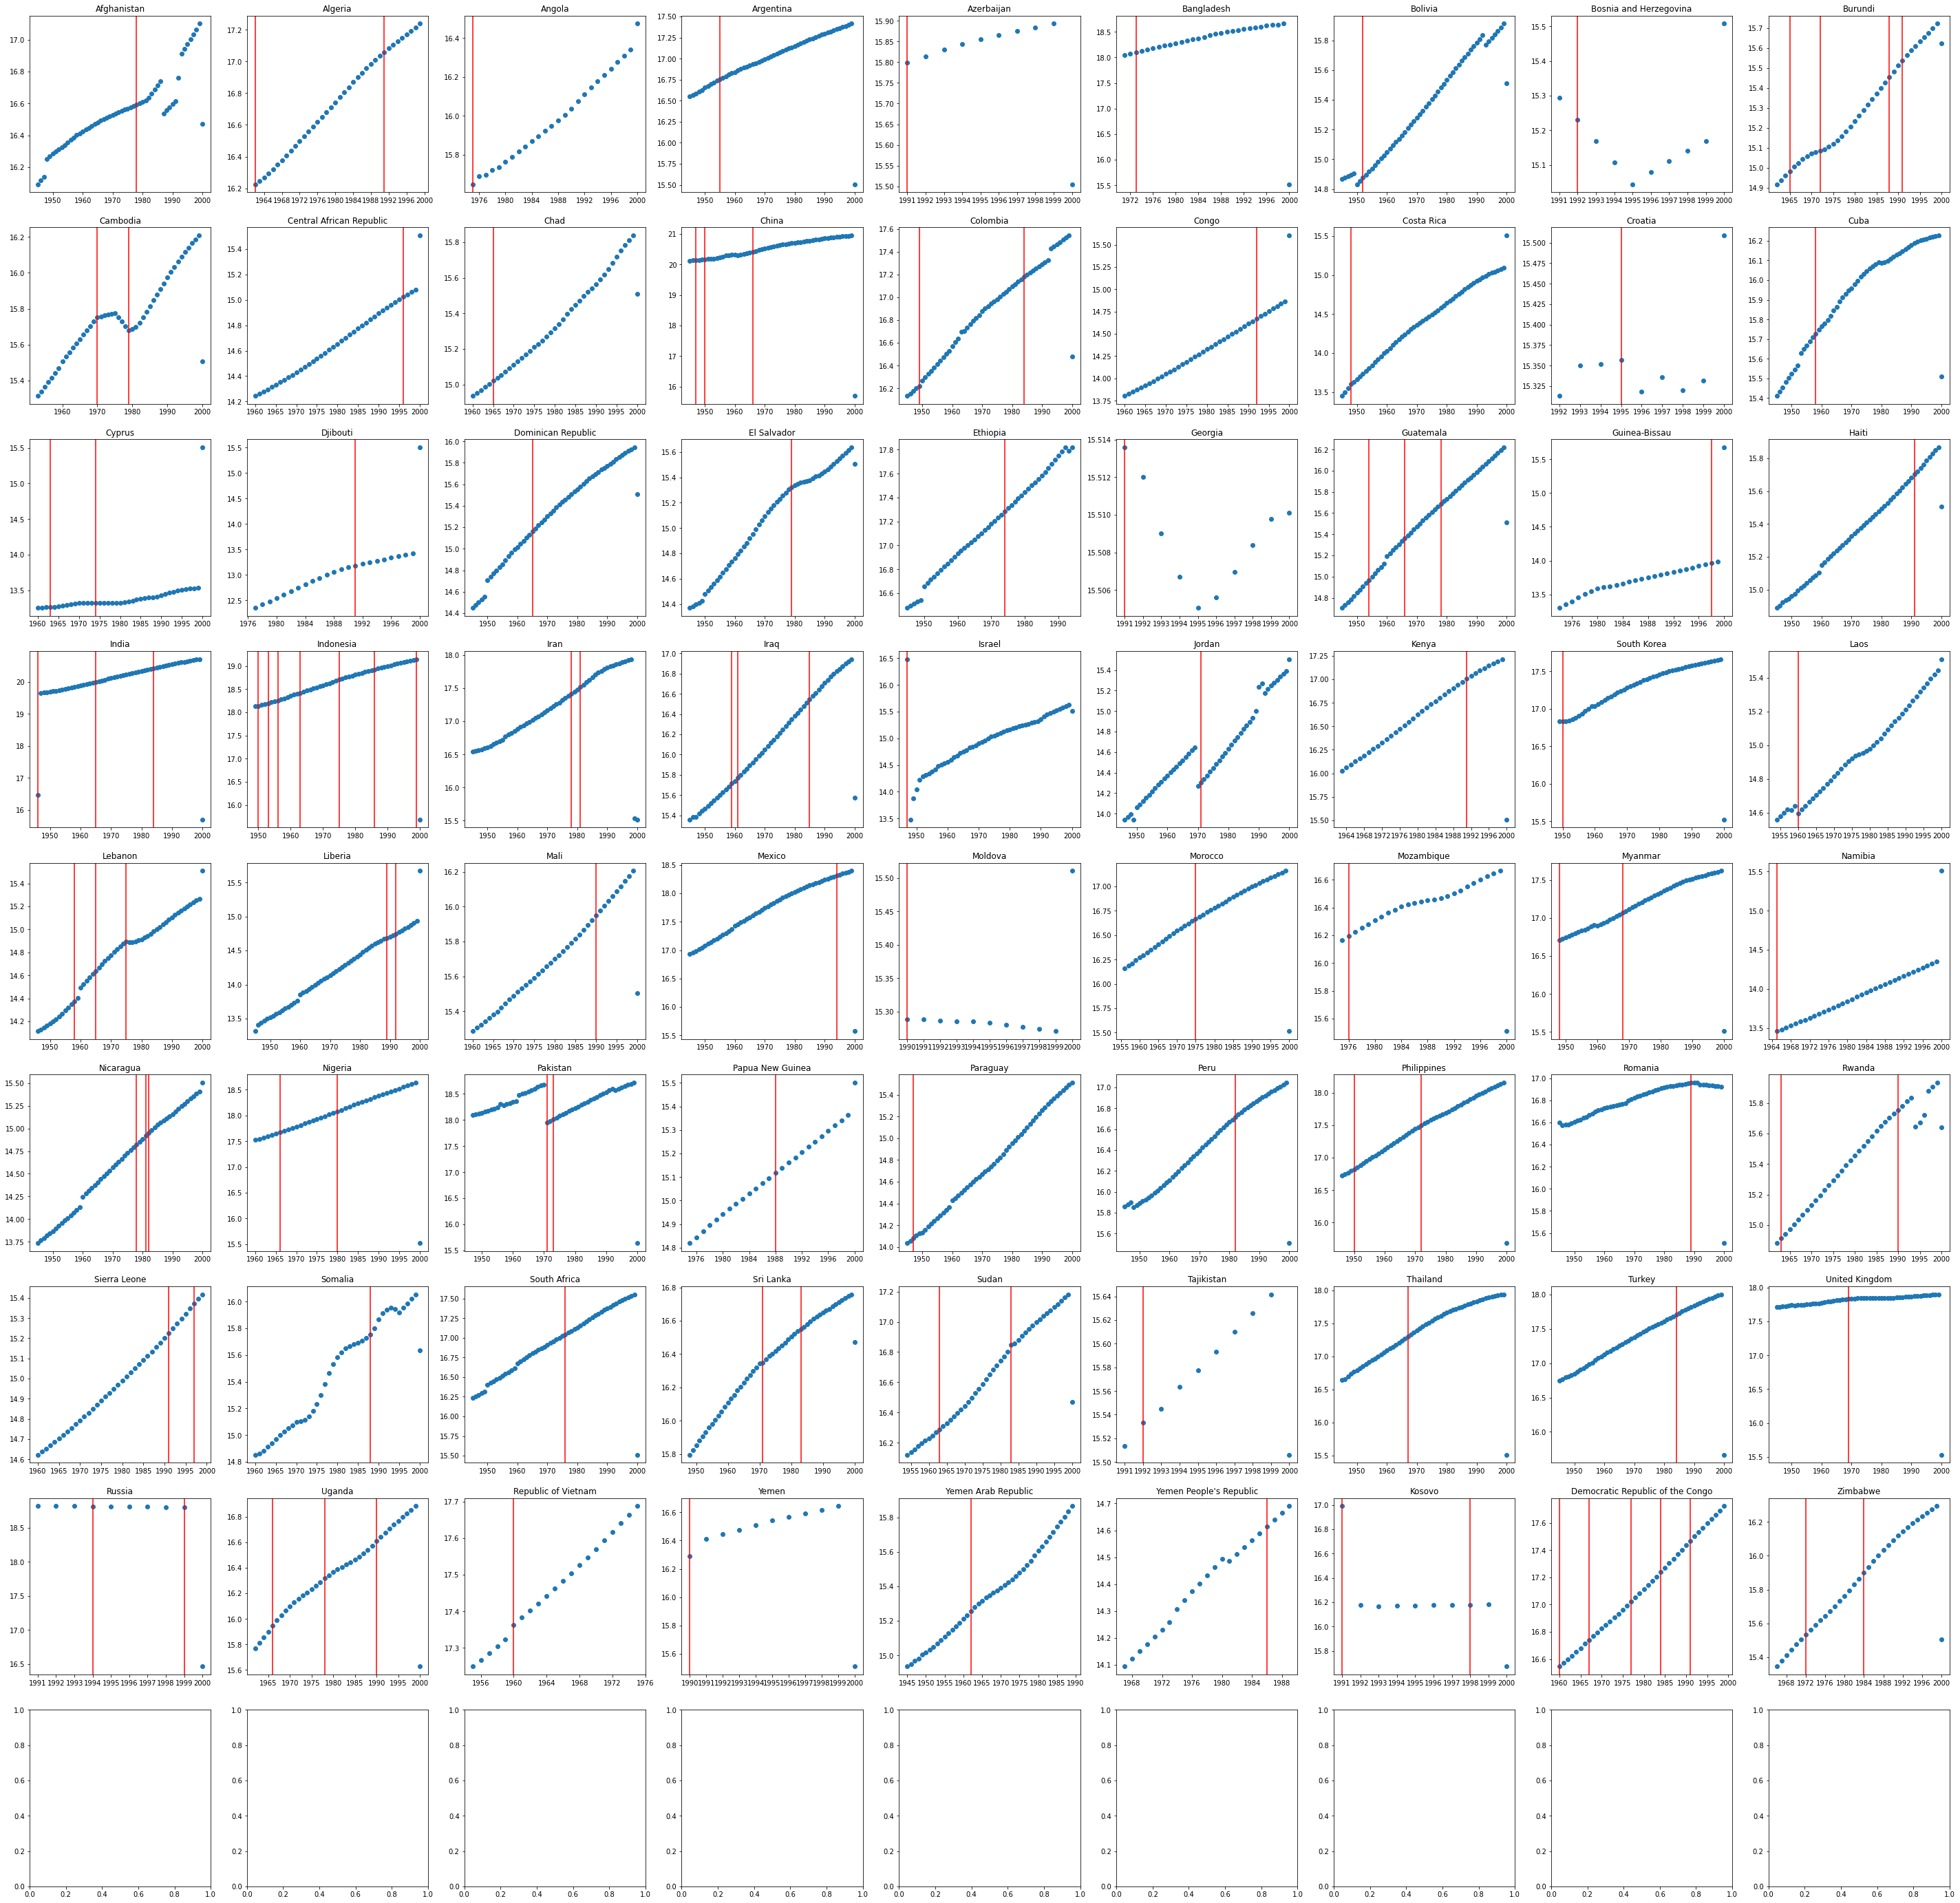

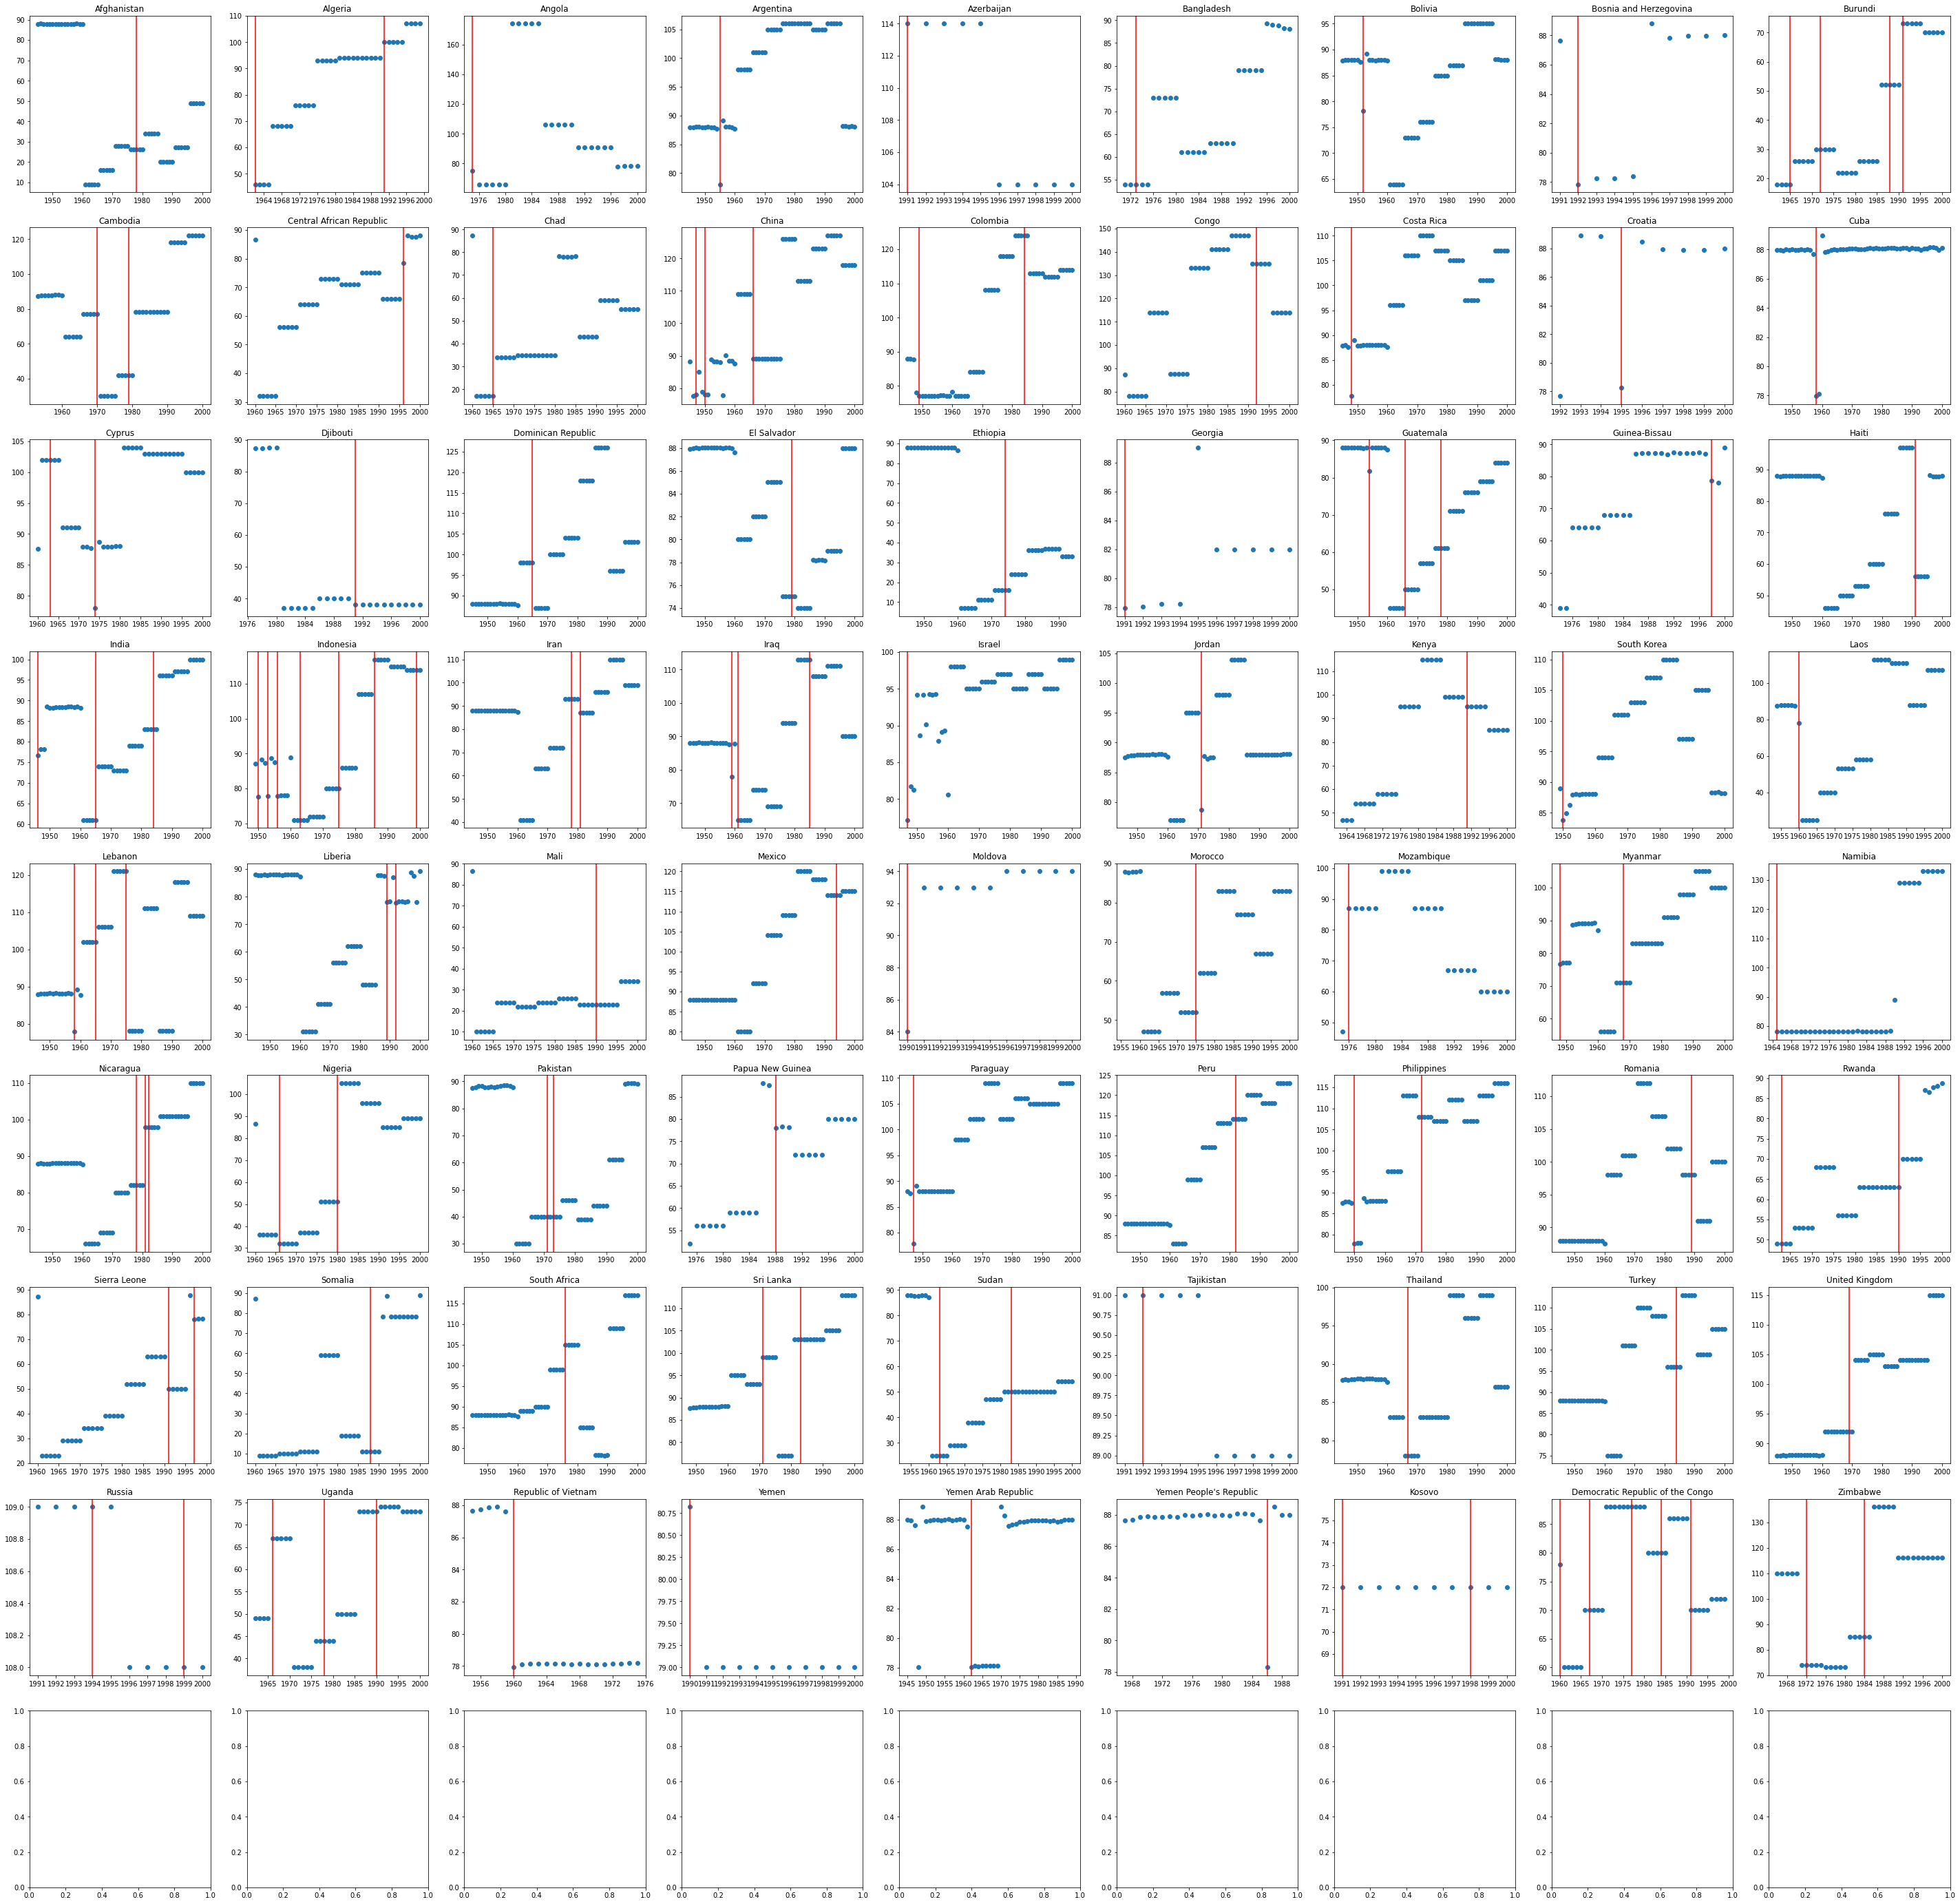

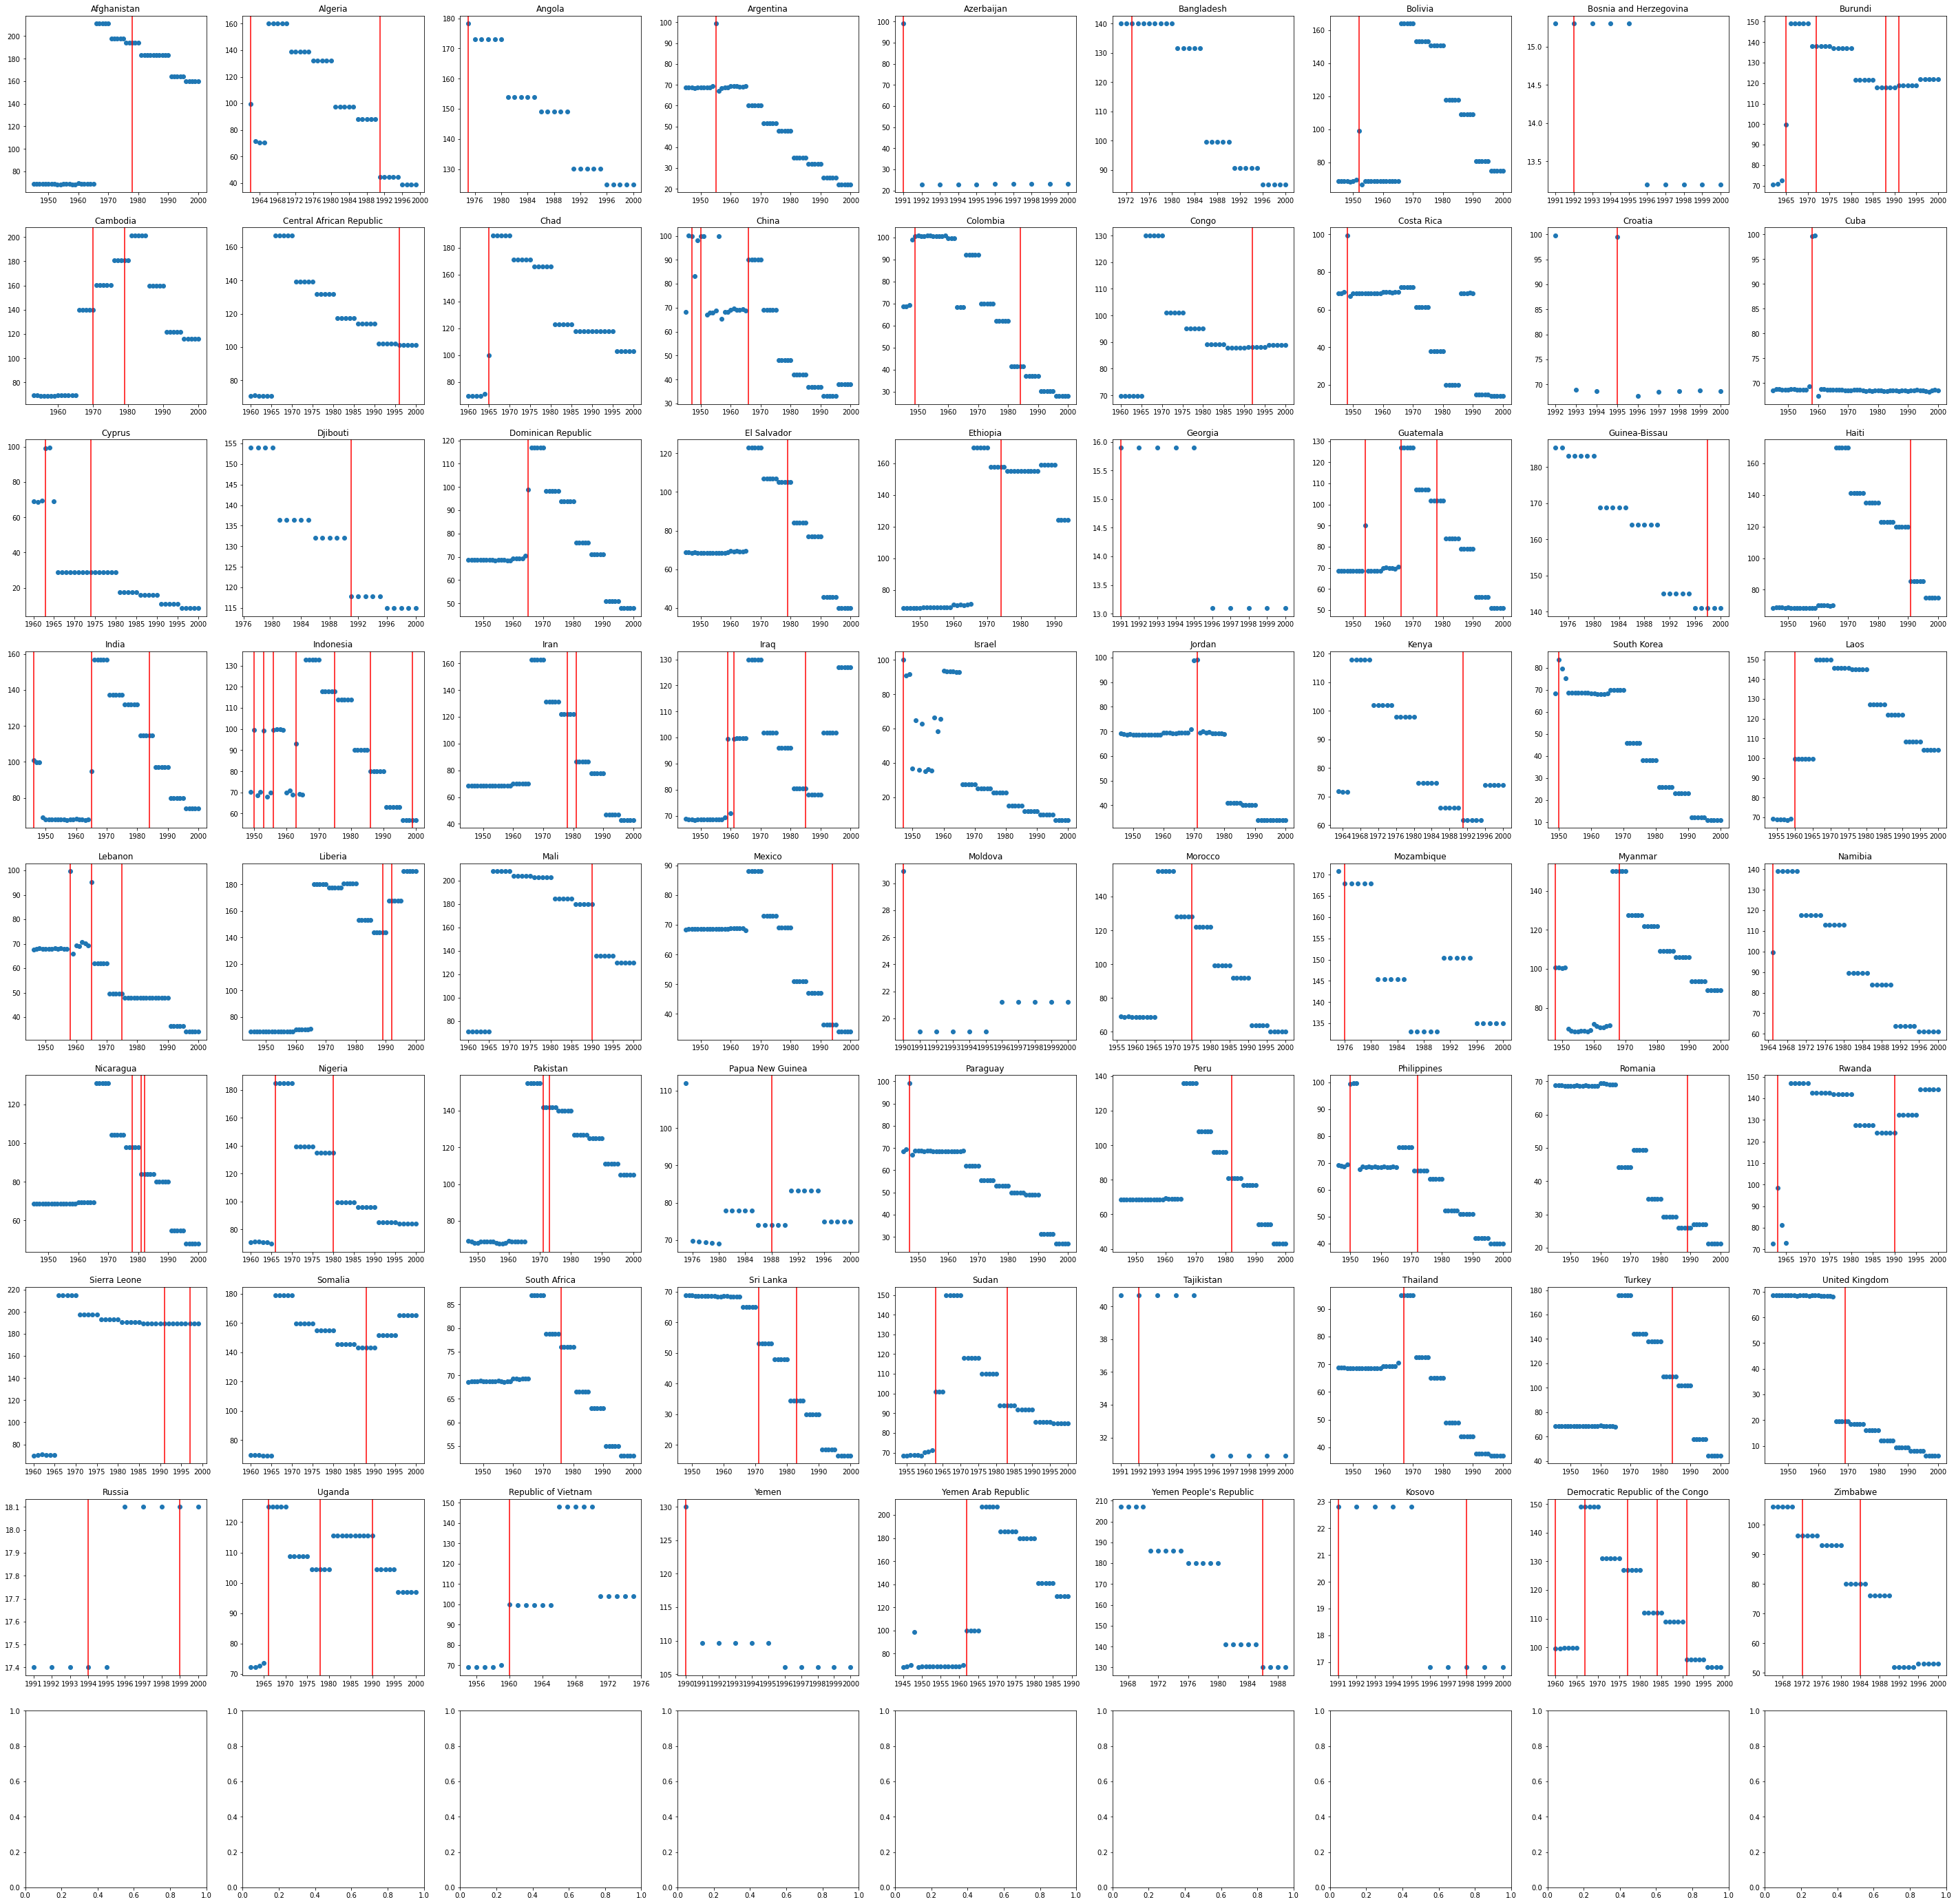

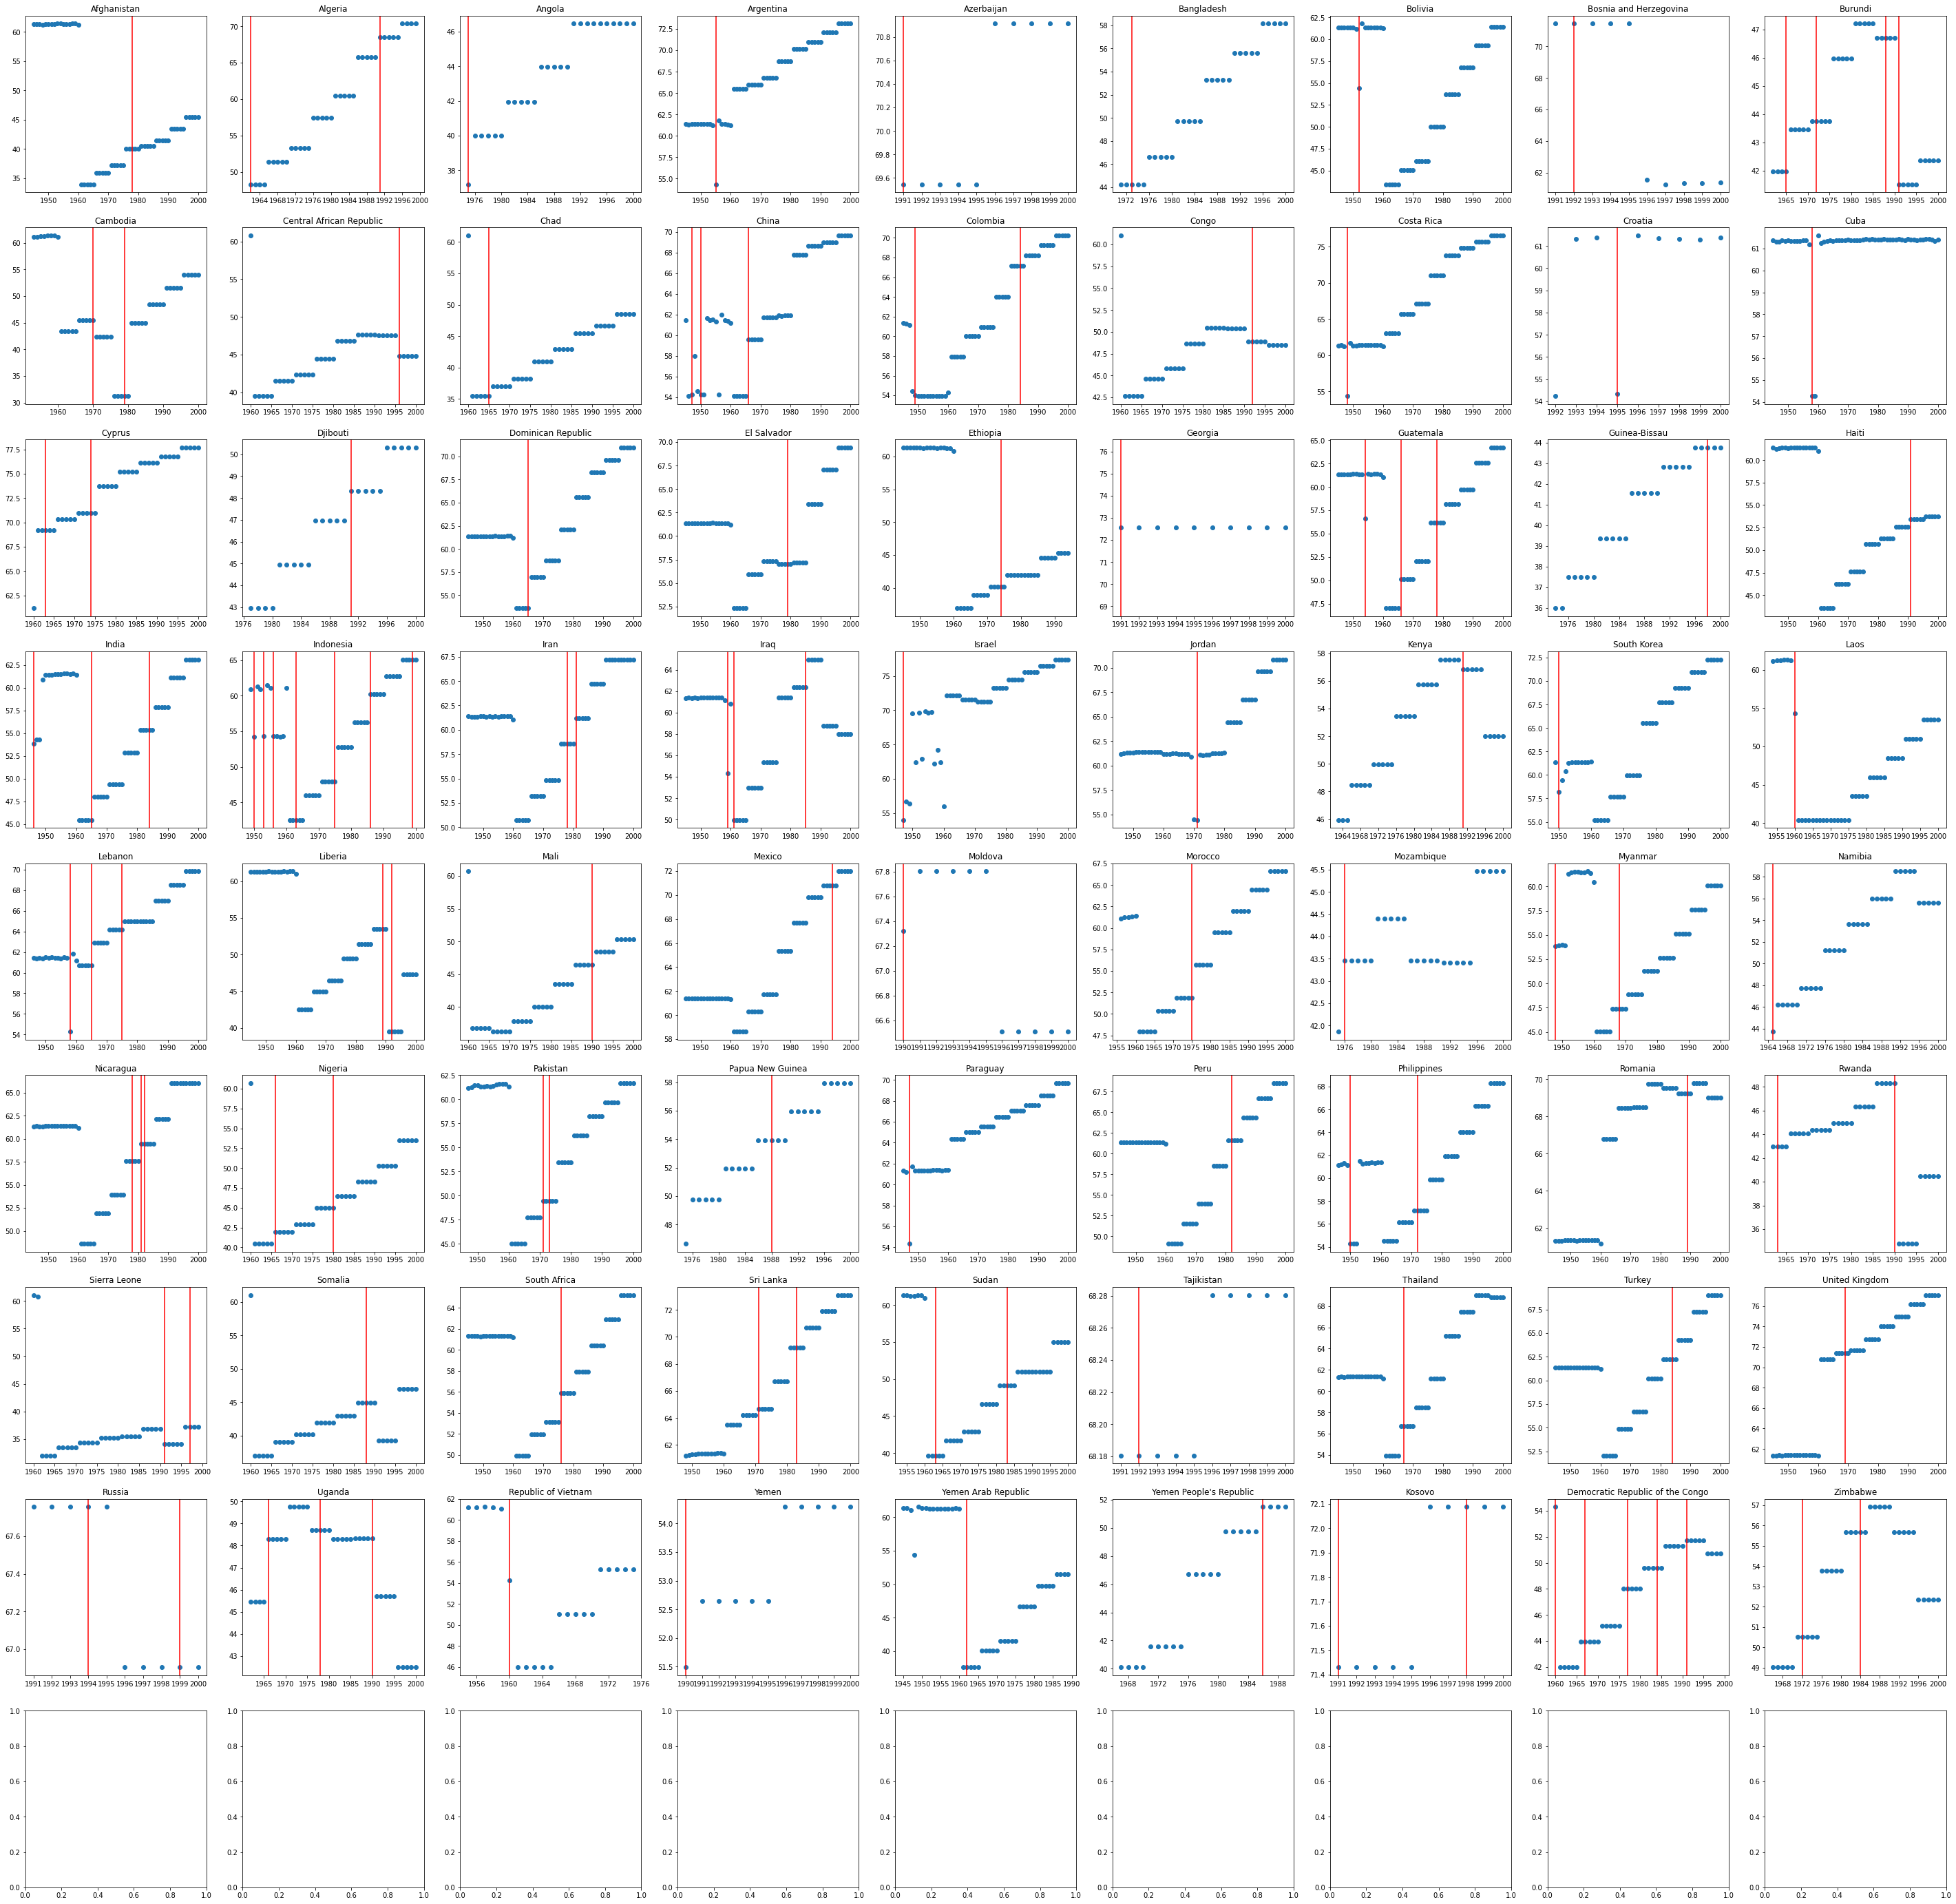

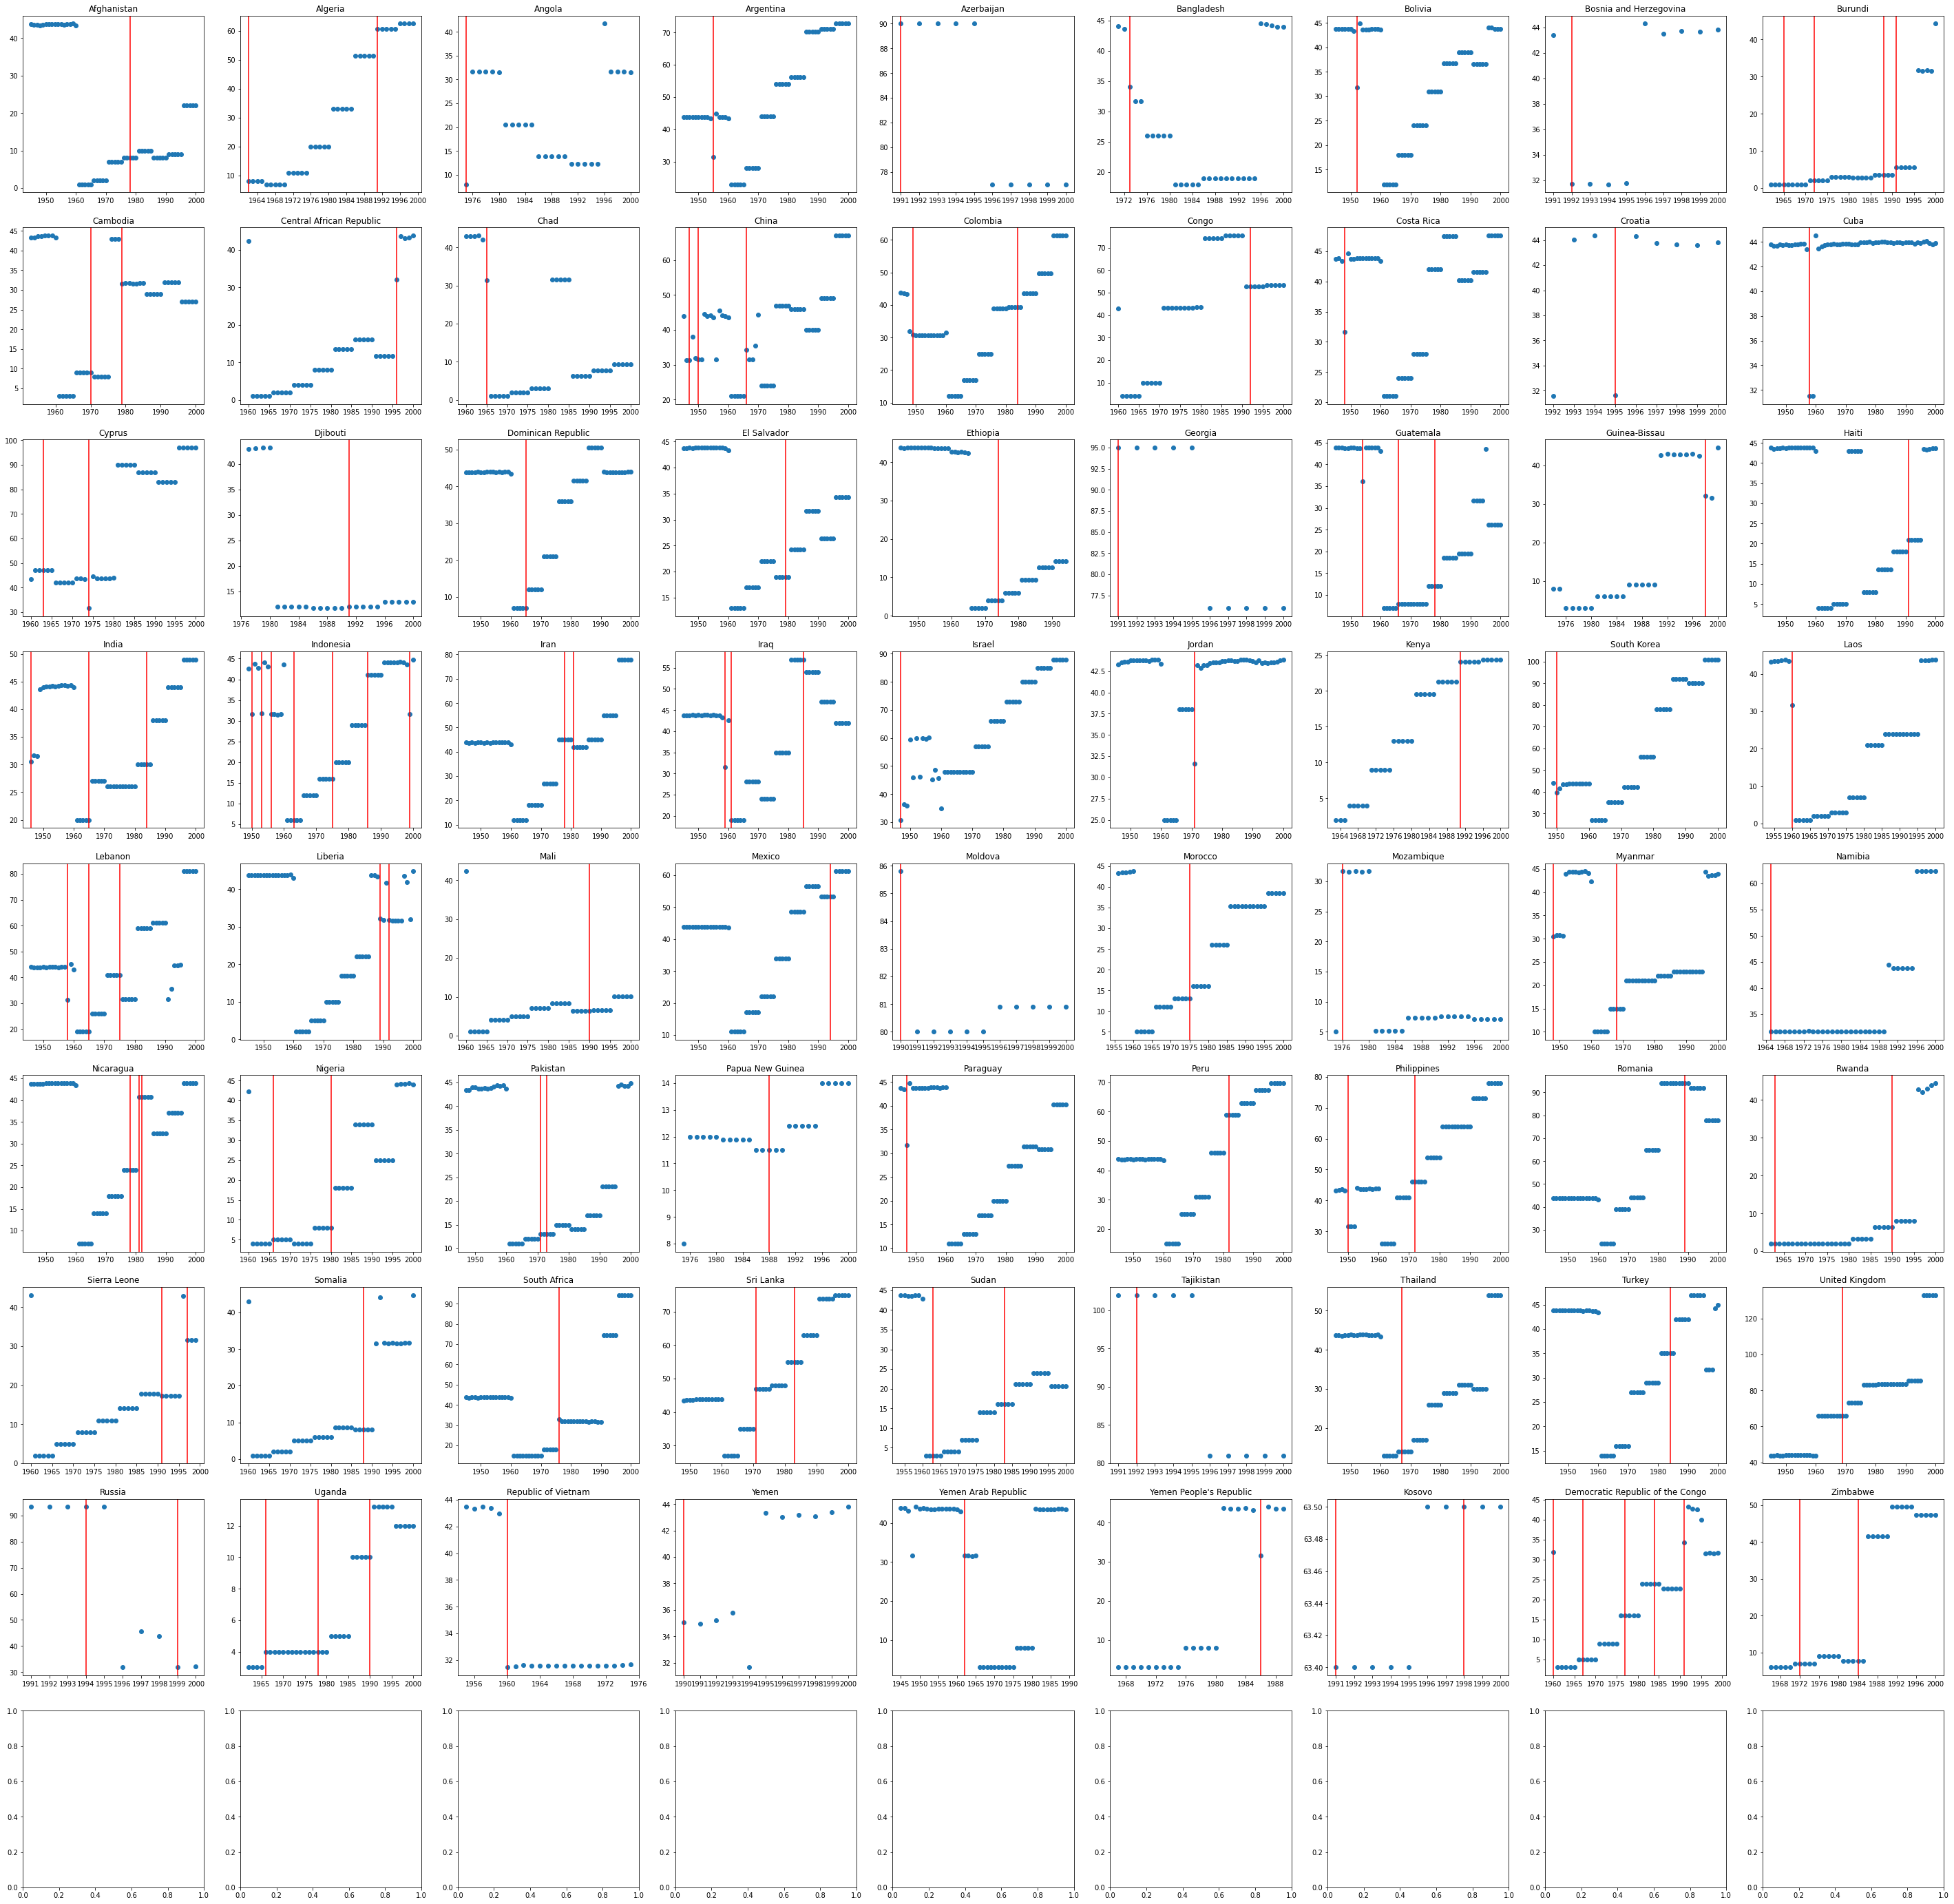

In [92]:
#iterate on the "high priority features"
for key in feat_subset:
    #create enough column and row for 
    fig, ax = plt.subplots(nrows=9, ncols=9, figsize=(50,50))
    j=0
    #iterate on the countries affected by civil war
    for i, country in enumerate(CW_countries):
        if i%9 == 0 and i != 0:
            j+=1
        plot_feat(sambanis, country, key, ax=ax[j,i%9], title=country)
    
    #save plot as pdf to enable lossless zooming using pdf viewer
    fig.savefig(fname="fig_"+var2label_s[key]+".pdf", format="pdf")

### Antoine observations
- GDP Growth : for several countries, the onset of CW is followed by a brutal drop (expected based on the replication work with Random Forest), it sometimes even becomes negative.
- Illiteracy (adult): hard to tell, it seems to decrease with time overall, did not notice brutal spike (somehow logic; people don't forget how to read because of civil war. maybe try to detect delayed effect?)
- Infant Mortality : definitely something, the onset are often associated with a big jump (ponctual)
- Life Expectancy : super obvious, on CW onset year, the value is usually much lower
- Military power : interesting as well, some "jump to a new plateau" can be observed (Vietnam for exemple) or just ponctual spike.
- Population (logged) : Nothing visible except for Laos
- Primary Commodity Export : sudden drop visible for african countries (Sierra Leone, Somalia, South Africa, Uganda, ..). Not visible for every single onset.
- Primary Education : ponctual drop on onset year
- Secondary Education : same as Primary. (Cuba seems interesting)

In [98]:
#load the border dataset
geodata = pd.read_csv("geodata.csv")

In [99]:
geodata

,country_code,country_name,country_border_code,country_border_name
0,AD,Andorra,FR,France
1,AD,Andorra,ES,Spain
2,AE,United Arab Emirates,OM,Oman
3,AE,United Arab Emirates,SA,Saudi Arabia
4,AF,Afghanistan,CN,China
...,...,...,...,...
723,ZM,Zambia,ZW,Zimbabwe
724,ZW,Zimbabwe,BW,Botswana
725,ZW,Zimbabwe,MZ,Mozambique
726,ZW,Zimbabwe,ZA,South Africa


In [110]:
def comp_neighbour_feat(df, country, geodata=geodata):
    tmp = list(geodata.loc[geodata["country_name"] == country]["country_border_name"])
    neigh_df = df.loc[df["country"].isin(tmp)]
    return neigh_df

In [111]:
cowcodes.loc[cowcodes["country"] == "Afghanistan"]

,StateAbb,cowcode,country
196,AFG,700,Afghanistan


In [112]:
geodata.loc[geodata["country_name"]=="Afghanistan"]

,country_code,country_name,country_border_code,country_border_name
4,AF,Afghanistan,CN,China
5,AF,Afghanistan,IR,Iran (Islamic Republic of)
6,AF,Afghanistan,PK,Pakistan
7,AF,Afghanistan,TJ,Tajikistan
8,AF,Afghanistan,TM,Turkmenistan
9,AF,Afghanistan,UZ,Uzbekistan


In [113]:
#return the values associated with the neighbouring countries
#very practical to compute any kind of stats on them!
comp_neighbour_feat(sambanis, "Afghanistan")

,cowcode,year,warstds,ptime,autonomy,popdense,army85,milper,trade,nmgdp,...,mirps3,sxpsq,pol4sq,decade1,decade2,decade3,decade4,proxregc,country,country_abb
1246,710,1945-01-01,0,12,0.005858,116.966856,157819.9204,151.709933,71.578024,4527.962959,...,0.376234,0.050435,61.385113,0,0,0,0,0.146336,China,CHN
1247,710,1946-01-01,0,24,0.000000,100.706551,181078.2145,132.386317,47.379103,3223.125632,...,0.261949,0.022304,46.854656,0,0,0,0,1.000000,China,CHN
1248,710,1947-01-01,1,30,0.000000,102.028569,181950.8091,133.119056,47.270288,3235.100446,...,0.000000,0.022267,25.000000,0,0,0,0,1.000000,China,CHN
1249,710,1948-01-01,0,42,0.000000,104.708751,210077.2142,173.845392,57.672336,3691.509690,...,0.000000,0.031597,25.000000,0,0,0,0,1.000000,China,CHN
1250,710,1949-01-01,0,54,0.000000,100.279922,194740.3814,147.342853,47.668467,3249.816226,...,0.000000,0.021977,25.000000,0,0,0,0,1.000000,China,CHN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6741,704,1996-01-01,0,72,0.000000,119.133533,130072.9965,121.858694,73.004614,4495.004001,...,0.000000,0.052840,81.000000,0,0,0,0,0.003906,Uzbekistan,UZB
6742,704,1997-01-01,0,84,0.000000,119.948176,130413.3279,121.881064,73.063804,4496.395029,...,0.000000,0.052816,81.000000,0,0,0,0,0.000977,Uzbekistan,UZB
6743,704,1998-01-01,0,96,0.000000,118.667912,130582.6211,121.031052,72.771353,4517.247506,...,0.000000,0.052625,81.000000,0,0,0,0,0.000244,Uzbekistan,UZB
6744,704,1999-01-01,0,108,0.000000,118.815052,130309.0554,120.613178,72.799310,4515.555689,...,0.000000,0.052727,81.000000,0,0,0,0,0.000061,Uzbekistan,UZB
